<a href="https://www.kaggle.com/code/mahdiislam/colorectal-cancer-tissue-segmentation-unet?scriptVersionId=180839552" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Colorectal Cancer Tissue Segmentation-Unet

This project involves the development and training of a U-Net model for the automated segmentation of colorectal cancer tissues from histological images. The model architecture includes multiple encoding and decoding blocks, skip connections, and a bottleneck layer, which are integral for capturing the complex features in medical images.

Features:
- Model Architecture: Implements a U-Net architecture with customizable depth and number of filters.
- Training and Validation: Includes detailed training and validation phases, with Dice-loss as loss function and Dice Coefficient and Jaccard Coefficient which is tracked over epochs.
- Performance Evaluation: The model's effectiveness is evaluated on a validation dataset with visualizations of the learning curves for training and validation losses.
- Sample Display: Outputs segmented images alongside the original inputs for visual inspection of model performance. Can be found on: [Inference Notebook](https://www.kaggle.com/code/mahdiislam/colorectal-cancer-segmentation-unet-inference)

Implementation Details:
- PyTorch Framework: The project is implemented using PyTorch and Weights & Biases.
- Dynamic Training Configuration: Training parameters such as batch size, learning rate, and number of epochs are configurable.
- Resource Management: Code includes commands for GPU memory management to ensure efficient resource use during training.

# Downloading packages

In [29]:
!pip install -q segmentation_models_pytorch


In [30]:
!pip install wandb --upgrade

# Import Libraries

In [31]:
import os 
import gc
import copy
import time
import pandas as pd
import numpy as np
import glob
import random
from tqdm import tqdm
from collections import defaultdict
from IPython import display as ipd

import cv2
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.cuda import amp
import torch.optim as optim
from torch.optim import Adam
from torch.optim import lr_scheduler 
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
# from torch.utils.tensorboard import SummaryWriter

import segmentation_models_pytorch as smp

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, StratifiedGroupKFold
from sklearn.preprocessing import MinMaxScaler

import wandb

# For colored terminal text
from colorama import Fore, Back, Style
c_  = Fore.GREEN
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

In [32]:
try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    api_key = user_secrets.get_secret("WANDB")
    wandb.login(key=api_key)
    anonymous = None
except:
    anonymous = "must"
    print('To use your W&B account,\nGo to Add-ons -> Secrets and provide your W&B access token. Use the Label name as WANDB. \nGet your W&B access token from here: https://wandb.ai/authorize')

wandb: Currently logged in as: mahdiiut079 (mi79). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Configuration Parameters

In [33]:
class CFG:
    seed              = 101
    debug             = False # set debug=False for Full Training
    exp_name          = 'Unet++'
    comment           = 'unet-efficientnet_b1-attention_scse-dropout-224x224-split2'
    model_name        = 'Unet++'
    backbone          = 'efficientnet-b1'
    train_bs          = 8
    valid_bs          = 200
    img_size          = [224, 224]
    epochs            = 30
    lr                = 1e-3
    scheduler         = 'CosineAnnealingWarmRestarts'
    min_lr            = 1e-6
    T_max             = int(30000/train_bs*epochs)+50
    T_0               = 15
    warmup_epochs     = 5
    wd                = 1e-6
    n_accumulate      = max(1, 32//train_bs)
    n_fold            = 5
    num_classes       = 1
    device            = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#     aux_params        = {'classes':1, 'pooling':'avg', 'dropout':0.5, 'activation':None}
    decoder_attention_type = 'scse'


# Reproducibility

In [34]:
def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    print('> SEEDING DONE')
    
set_seed(CFG.seed)

> SEEDING DONE


# Dataset loading & preprocessing

In [35]:
# Directory containing files
directory = '/kaggle/input/colorectal-cancer-wsi/EBHI-SEG'

# Create a DataFrame containing file paths for images and masks
df = pd.DataFrame(columns=['image_files', 'mask_files'])
cancer_types = ['Normal', 'Polyp', 'Low-grade IN', 'Adenocarcinoma', 'High-grade IN', 'Serrated adenoma']
label2id = {'Normal': 0, 'Polyp':1, 'Low-grade IN':2, 'Adenocarcinoma':3, 'High-grade IN':4, 'Serrated adenoma':5}

for cancer_type in cancer_types:
    image_dir = os.path.join(directory, cancer_type, 'image')
    mask_dir = os.path.join(directory, cancer_type, 'label')

    # Check if the image and mask directories exist
    if not os.path.exists(image_dir) or not os.path.exists(mask_dir):
        print(f"Directory not found for {cancer_type}. Skipping...")
        continue

    image_files = sorted(os.listdir(image_dir))

    for file in image_files:
        image_file = os.path.join(image_dir, file)
        mask_file = os.path.join(mask_dir, file.replace('.jpg', '_mask.jpg'))  # Assuming mask file name is derived from image file name

        # Check if mask file exists
        if os.path.isfile(mask_file):
            df = pd.concat([df, pd.DataFrame({'image_files': [image_file], 'mask_files': [mask_file]})], ignore_index=True)

# # Shuffle the DataFrame
# df = df.sample(frac=1).reset_index(drop=True)

# Print the length of the DataFrame
print("Total number of samples:", len(df))


Total number of samples: 2226


In [36]:
# print(df['image_files'][1387])
# print(df['image_files'][1290])

In [37]:
def label_image(img_path):
    for cancer_type in cancer_types:
        if cancer_type in img_path:
            return cancer_type
        
df['label names'] = df['image_files'].copy().map(label_image)

In [38]:
def label_image_num(img_path):
    for label, cancer_type in enumerate(cancer_types):
        if cancer_type in img_path:
            return label
        
df['label'] = df['image_files'].copy().map(label_image_num)

In [39]:
# def cal_mean(img_path):
#     img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
#     return np.mean(img)

# def cal_std(img_path):
#     img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
#     return np.std(img)

# df['mean'] = df['image_files'].copy().map(cal_mean)
# df['std'] = df['image_files'].copy().map(cal_std)

In [40]:
len(df[df['label names']=='Low-grade IN'])
len(df[df['label']==2])

637

In [41]:
df.sample(10)

image_files  \
1347  /kaggle/input/colorectal-cancer-wsi/EBHI-SEG/A...   
2019  /kaggle/input/colorectal-cancer-wsi/EBHI-SEG/H...   
37    /kaggle/input/colorectal-cancer-wsi/EBHI-SEG/N...   
356   /kaggle/input/colorectal-cancer-wsi/EBHI-SEG/P...   
1133  /kaggle/input/colorectal-cancer-wsi/EBHI-SEG/L...   
198   /kaggle/input/colorectal-cancer-wsi/EBHI-SEG/P...   
959   /kaggle/input/colorectal-cancer-wsi/EBHI-SEG/L...   
690   /kaggle/input/colorectal-cancer-wsi/EBHI-SEG/L...   
374   /kaggle/input/colorectal-cancer-wsi/EBHI-SEG/P...   
1714  /kaggle/input/colorectal-cancer-wsi/EBHI-SEG/A...   

                                             mask_files     label names  label  
1347  /kaggle/input/colorectal-cancer-wsi/EBHI-SEG/A...  Adenocarcinoma      3  
2019  /kaggle/input/colorectal-cancer-wsi/EBHI-SEG/H...   High-grade IN      4  
37    /kaggle/input/colorectal-cancer-wsi/EBHI-SEG/N...          Normal      0  
356   /kaggle/input/colorectal-cancer-wsi/EBHI-SEG/P...           Polyp      1  
1133  /kaggle/input/colorectal-cancer-wsi/EBHI-SEG/L...    Low-grade IN      2  
198   /kaggle/input/colorectal-cancer-wsi/EBHI-SEG/P...           Polyp      1  
959   /kaggle/input/colorectal-cancer-wsi/EBHI-SEG/L...    Low-grade IN      2  
690   /kaggle/input/colorectal-cancer-wsi/EBHI-SEG/L...    Low-grade IN      2  
374   /kaggle/input/colorectal-cancer-wsi/EBHI-SEG/P...           Polyp      1  
1714  /kaggle/input/colorectal-cancer-wsi/EBHI-SEG/A...  Adenocarcinoma      3

In [42]:
# Initialize sums and pixel count
mean_sums = np.array([0.0, 0.0, 0.0])
std_sums = np.array([0.0, 0.0, 0.0])
num_pixels = 0

# Process each image
for path in df['image_files']:
    image = Image.open(path)
    image_np = np.array(image) / 255.0  # Convert to 0-1 range if needed
    num_pixels += image_np.shape[0] * image_np.shape[1]
    mean_sums += image_np.mean(axis=(0, 1))  # Mean over height and width
    std_sums += image_np.std(axis=(0, 1))  # Std deviation over height and width

# Calculate mean and std dev for each channel
mean_channels = mean_sums / len(df)
std_channels = std_sums / len(df)

print("Mean per channel:", mean_channels)
print("Standard deviation per channel:", std_channels)

Mean per channel: [0.519624   0.34783007 0.68143765]
Standard deviation per channel: [0.22924705 0.24072345 0.14470555]


# Visualization utils

In [43]:
def plot_fig(df, label_name, nrows=3,ncols=9):

    fig,ax = plt.subplots(nrows, ncols, figsize=(27,9))
    plt.subplots_adjust(wspace=0, hspace=0)
    label_files = df[df['label names']==label_name]['image_files']
    
    for idx, img_path in enumerate(label_files.tolist()[:nrows*ncols]):
        img = Image.open(img_path)
#         idcol.rectangle(((0,0),(95,95)),outline='white')

        # Show the binary segmented image using Matplotlib
        plt.subplot(nrows, ncols, idx+1) 
        plt.imshow(np.array(img))
        plt.axis('off')

    plt.suptitle(f"{label_name}", y=0.94)

In [44]:
def plot_masks(df, label_name, nrows=3,ncols=9):

    fig,ax = plt.subplots(nrows, ncols, figsize=(27,9))
    plt.subplots_adjust(wspace=0, hspace=0)
    label_files = df[df['label names']==label_name]['mask_files']
    
    for idx, img_path in enumerate(label_files.tolist()[:nrows*ncols]):
        img = Image.open(img_path)
#         idcol.rectangle(((0,0),(95,95)),outline='white')
        plt.subplot(nrows, ncols, idx+1) 
        plt.imshow(np.array(img), cmap='gray')
        plt.axis('off')

    plt.suptitle(f"{label_name}", y=0.94)

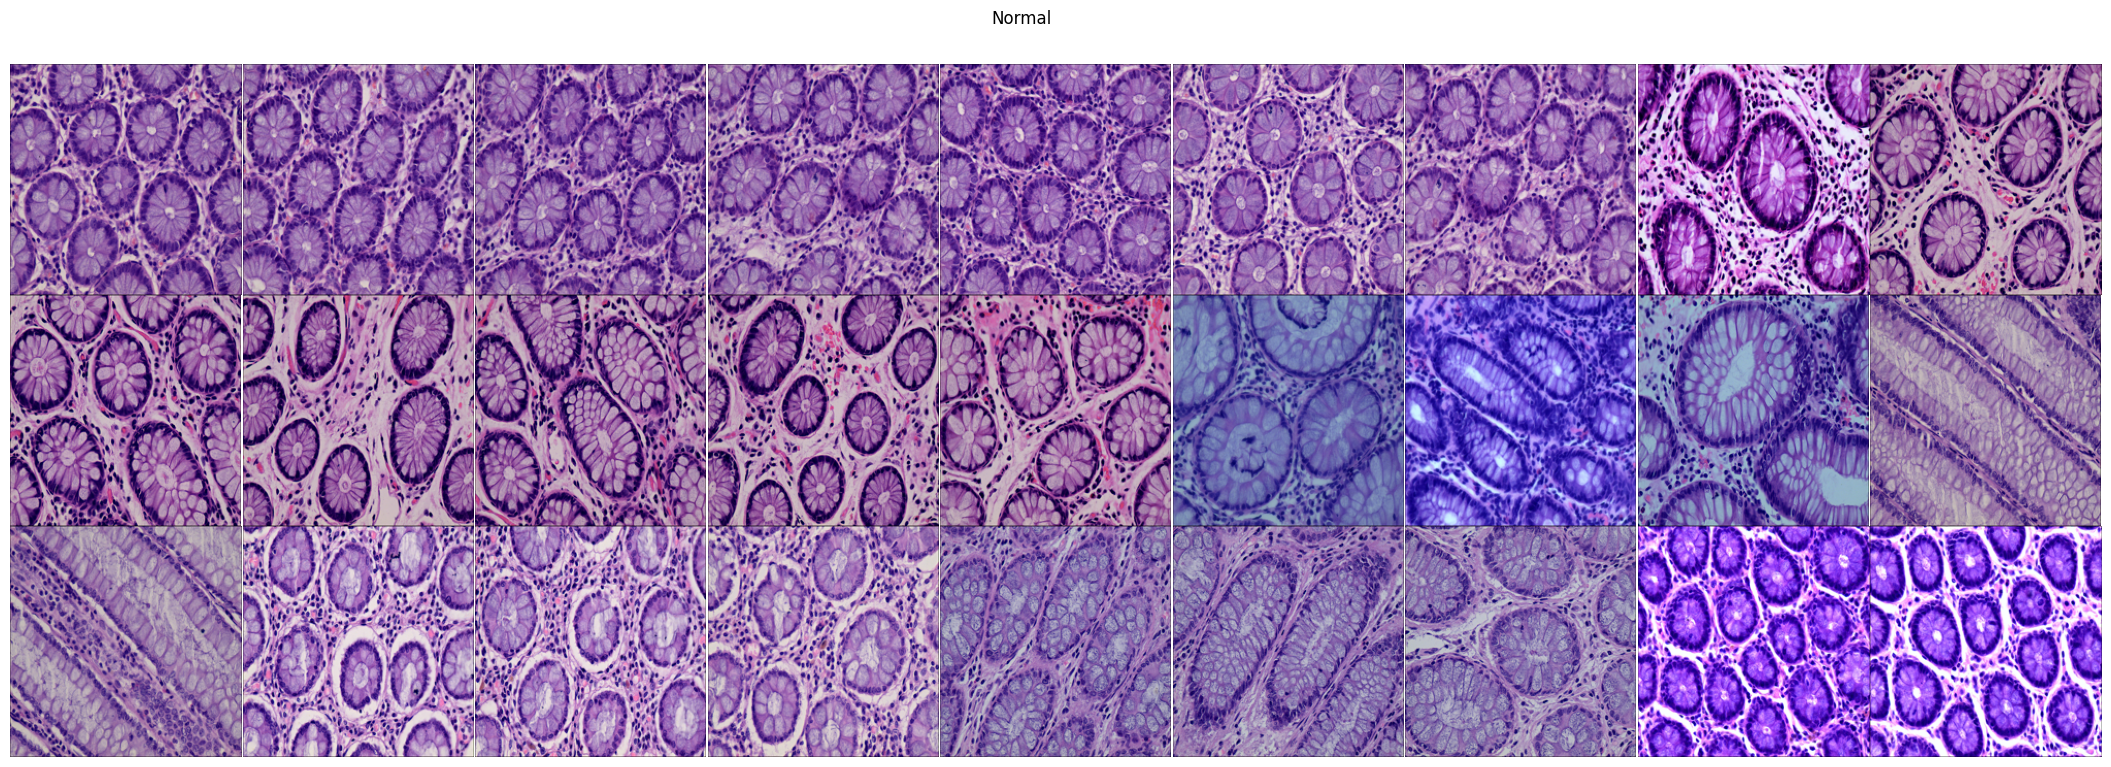

In [45]:
plot_fig(df, "Normal")

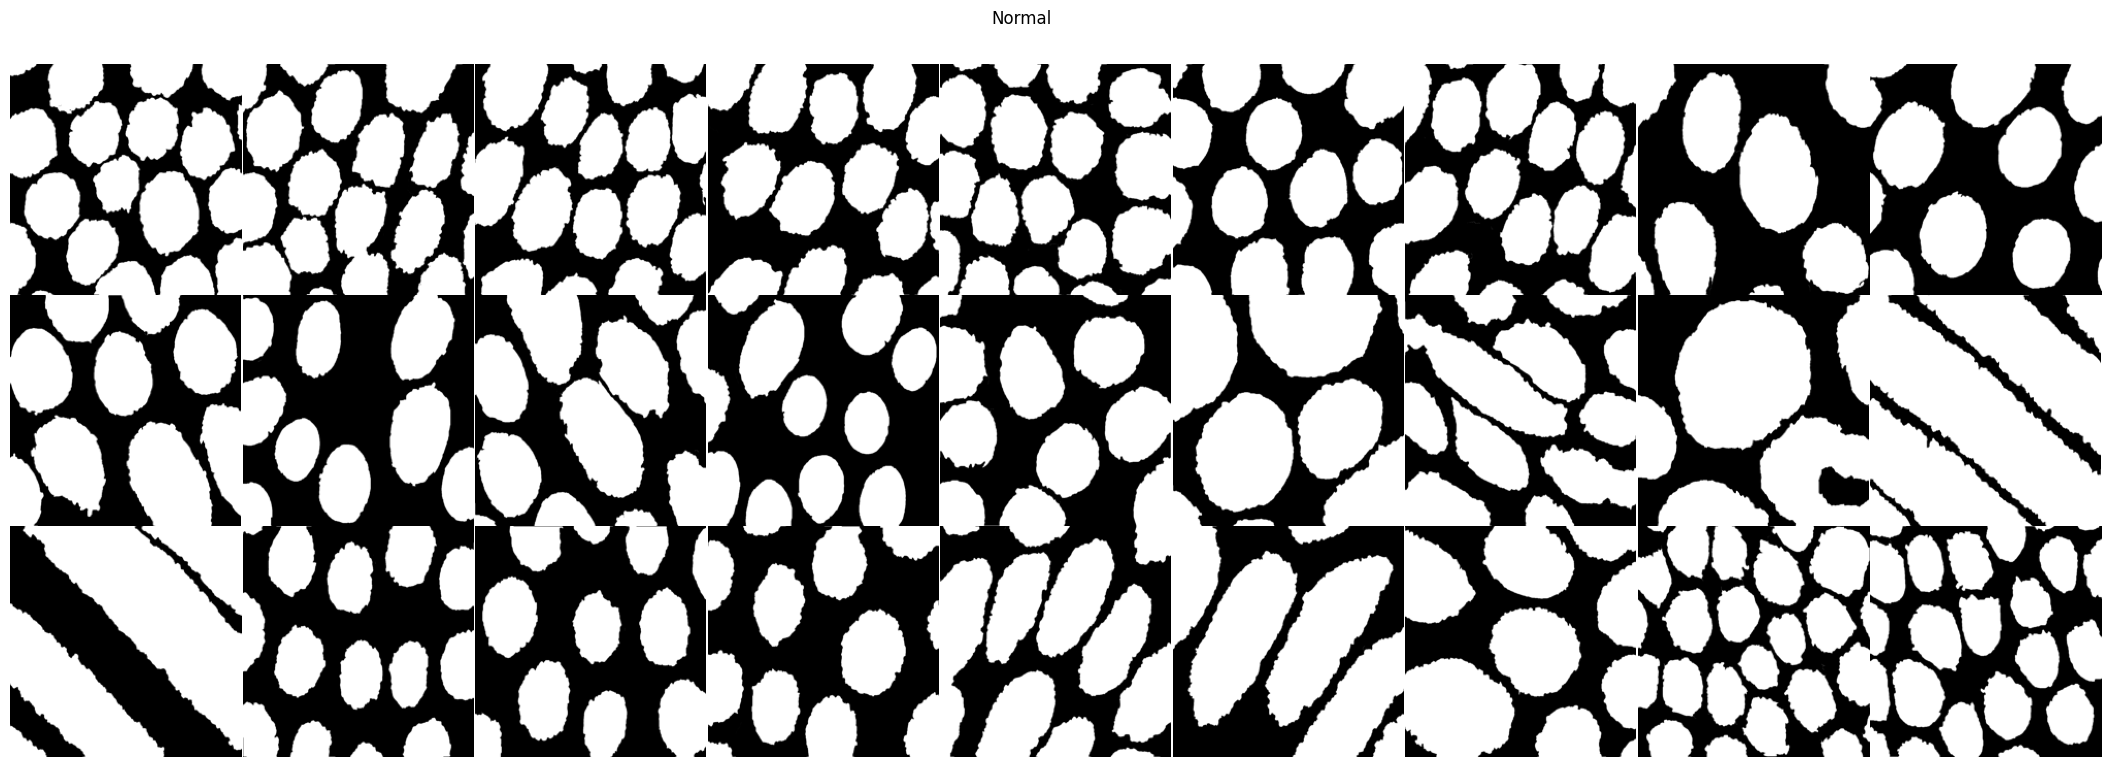

In [46]:
plot_masks(df, "Normal")

In [47]:
# Transpose the image and mask to have channels first
image = cv2.imread(df['image_files'][0])
mask = cv2.imread(df['mask_files'][0])
image_T = image.transpose()
mask_T = mask.transpose()
print(image_T.shape)
print(mask_T.shape)

(3, 224, 224)
(3, 224, 224)


In [48]:
image_PIL = Image.open(df['image_files'][500])
mask_PIL = Image.open(df['mask_files'][500])

In [49]:
np.unique(np.array(mask_PIL))

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 144,
       145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
       171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 18

(array([12905.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 37271.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

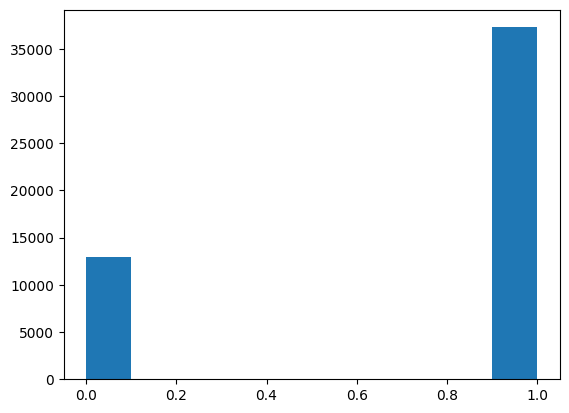

In [50]:
plt.hist((np.array(mask_PIL)/255).astype(int).reshape(-1))

(-0.5, 223.5, 223.5, -0.5)

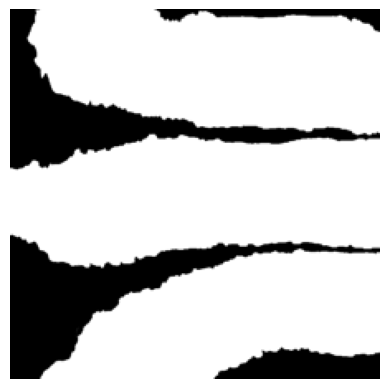

In [51]:
plt.imshow(np.array(mask_PIL), cmap='gray')
plt.axis('off')

# Create Folds

In [55]:
# Split the dataset into train and validation sets (90:10)
df_train, test_df = train_test_split(df, test_size=0.15, random_state=42, shuffle=True, stratify=df['label names'])

In [56]:
df_train = df_train.reset_index()

In [58]:
# Initialize StratifiedKFold with the specified number of splits and random state
skf = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)

# Create stratified folds and assign fold numbers to the validation indices
for fold, (train_idx, val_idx) in enumerate(skf.split(df_train, df_train['label names'])):
    # Assign the fold number to the validation indices
    df_train.loc[val_idx, 'fold'] = fold

# Display the distribution of images per fold and label
display(df_train.groupby(['fold', 'label names'])['image_files'].count())

fold  label names     
0.0   Adenocarcinoma      136
      High-grade IN        32
      Low-grade IN        108
      Normal               13
      Polyp                80
      Serrated adenoma     10
1.0   Adenocarcinoma      135
      High-grade IN        32
      Low-grade IN        108
      Normal               13
      Polyp                81
      Serrated adenoma     10
2.0   Adenocarcinoma      135
      High-grade IN        32
      Low-grade IN        108
      Normal               13
      Polyp                81
      Serrated adenoma      9
3.0   Adenocarcinoma      135
      High-grade IN        31
      Low-grade IN        108
      Normal               13
      Polyp                81
      Serrated adenoma     10
4.0   Adenocarcinoma      135
      High-grade IN        31
      Low-grade IN        109
      Normal               13
      Polyp                80
      Serrated adenoma     10
Name: image_files, dtype: int64

# Creating Dataset Object

In [28]:
# class WSI_Dataset(Dataset):
#     def __init__(self, dataframe, image_transform=None, mask_transform=None):
#         self.data = dataframe
#         self.image_transform = image_transform
#         self.mask_transform = mask_transform
        
#     def __len__(self):
#         return len(self.data)
    
#     def __getitem__(self, idx):
#         # Load image and mask
#         row = self.data.iloc[idx]
#         image_path = row['image_files']  # Assuming 'image_files' is the column containing filepaths
#         mask_path = row['mask_files']    # Assuming 'mask_files' is the column containing mask filepaths
        
#         try:
#             image = Image.open(image_path).convert("RGB")
#             mask = Image.open(mask_path).convert("L")  # Convert to grayscale mask
            
#             if self.image_transform:
#                 image = self.image_transform(image)
                
#             if self.mask_transform:
#                 mask = self.mask_transform(mask)
            
#             return image, mask
        
#         except Exception as e:
#             print(f"Error loading image or mask at index {idx}: {e}")
#             return None, None

In [31]:
def add_gaussian_noise(image, stddev=0.1):
    noise = torch.randn_like(image) * stddev
    return image + noise

def train_image_transforms():
    return v2.Compose([
        v2.ToImage(),  # Convert input to image format
        v2.ToDtype(torch.float32, scale=True),  # Convert image to float32 and scale
    ])

def mask_transforms():
    return v2.Compose([
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Lambda(lambda x: torch.where(x > 0.5, torch.tensor(1.), torch.tensor(0.)))  # Thresholding operation
    ])

def valid_transforms():
    return v2.Compose([
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.519624, 0.34783007, 0.68143765], std=[0.22924705, 0.24072345, 0.14470555])
    ])


In [32]:
class WSI_Dataset(Dataset):
    def __init__(self, dataframe, train=True):
        self.data = dataframe
        self.train = train
        self.labels = self.data['label'].tolist()  # Store labels for easy access
        
        if train:
            self.image_transform = train_image_transforms()
            self.mask_transform = mask_transforms()
        else:
            self.image_transform = valid_transforms()
            self.mask_transform = mask_transforms()  # Keep the transforms ready even for validation

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image_path = row['image_files']
        image = Image.open(image_path).convert("RGB")
        label = row['label']

        # Check if the mask path exists and is not NaN
        mask = None
        if 'mask_files' in row and pd.notna(row['mask_files']):
            mask_path = row['mask_files']
            mask = Image.open(mask_path).convert("L")  # Convert to grayscale mask

        # Apply the image transformation
        if self.image_transform:
            image = self.image_transform(image)

        # Apply the mask transformation if mask is loaded
        if mask is not None and self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask, label


In [33]:
def make_weights_for_balanced_classes(dataframe, nclasses):
    count = [0] * nclasses
    for item in dataframe['label']:  # Assuming the label column is named 'label'
        count[item] += 1
    
    weight_per_class = [0.] * nclasses
    N = float(sum(count))
    for i in range(nclasses):
        weight_per_class[i] = N / float(count[i])
    
    total_weight = sum(weight_per_class)
    normalized_weight_per_class = [w / total_weight for w in weight_per_class]
    
    weight = [0] * len(dataframe)
    for idx, val in enumerate(dataframe['label']):
        weight[idx] = normalized_weight_per_class[val]
    
    return weight

In [34]:
class RandomAugmentation:
    def __init__(self):
        self.transforms = [
            v2.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
            v2.GaussianBlur(kernel_size=(3, 7), sigma=(0.1, 3.)),
            v2.RandomAdjustSharpness(sharpness_factor=2),
            v2.Lambda(add_gaussian_noise)
        ]
    
    def __call__(self, img):
        num_transforms = random.randint(1, len(self.transforms))
        selected_transforms = random.sample(self.transforms, num_transforms)
        transform = v2.Compose(selected_transforms+[v2.Normalize(mean=[0.519624, 0.34783007, 0.68143765], std=[0.22924705, 0.24072345, 0.14470555])]  # Normalize the image
                              )
        return transform(img)

In [35]:
class Augmented_WSI_Dataset(Dataset):
    def __init__(self, original_dataset, num_augmented_images, num_copies=2):
        self.original_dataset = original_dataset
        self.num_augmented_images = num_augmented_images
        self.num_copies = num_copies

        self.original_images = list(range(len(self.original_dataset)))
        self.augmented_images = random.sample(self.original_images, self.num_augmented_images)
        self.total_images = len(self.original_dataset) + (self.num_augmented_images * self.num_copies)
        
        self.augmentation_transform = RandomAugmentation()

        # Get labels of augmented images
        labels = [self.original_dataset[idx][2] for idx in self.augmented_images]
        df_aug = pd.DataFrame({'label': labels})
        self.weights = make_weights_for_balanced_classes(df_aug, nclasses=len(set(labels)))
        self.sampler = WeightedRandomSampler(self.weights, num_samples=len(self.weights), replacement=True)

    def __len__(self):
        return self.total_images

    def __getitem__(self, idx):
        if idx < len(self.original_dataset):
            image, mask, label = self.original_dataset[idx]
        else:
            aug_idx = next(iter(self.sampler))
            img_idx = self.augmented_images[aug_idx // self.num_copies]
            image, mask, label = self.original_dataset[img_idx]
            if self.augmentation_transform:
                image = self.augmentation_transform(image)
                
        return image, mask, label


In [36]:
# # Assuming `df` is your DataFrame containing image and mask file paths
# original_dataset = WSI_Dataset(df, train=True)

# # Create the augmented dataset with a certain number of augmented images
# num_augmented_images = 1200  # specify the number of images to augment
# augmented_dataset = Augmented_WSI_Dataset(original_dataset, num_augmented_images, num_copies=2)

In [37]:
# def add_gaussian_noise(image, stddev=0.1):
#     noise = torch.randn_like(image) * stddev
#     return image + noise

# # def threshold_mask(x, threshold=0.5):
# #     return torch.where(x > threshold, torch.tensor(1.), torch.tensor(0.))

# def train_image_transforms():
#     return v2.Compose([
#         v2.ToImage(),  # Convert input to image format
#         v2.ToDtype(torch.float32, scale=True),  # Convert image to float32 and scale
# #         v2.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),  # Apply color jitter
# #         v2.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.)),  # Apply Gaussian blur
# #         v2.RandomAdjustSharpness(sharpness_factor=2),  # Adjust sharpness randomly
# #         v2.RandomAutocontrast(),  # Apply random autocontrast
# #         v2.RandomEqualize(),  # Apply random equalization
#         v2.Normalize(mean=[0.519624, 0.34783007, 0.68143765], std=[0.22924705, 0.24072345, 0.14470555]),  # Normalize the image
# #         v2.Lambda(add_gaussian_noise)  # Add Gaussian noise
#     ])

# def mask_transforms():
#     return v2.Compose([
#         v2.ToImage(),
#         v2.ToDtype(torch.float32, scale=True),
#         v2.Lambda(lambda x: torch.where(x > 0.5, torch.tensor(1.), torch.tensor(0.)))  # Thresholding operation
#     ])

# def valid_transforms():
#     return v2.Compose([
#         v2.ToImage(),
#         v2.ToDtype(torch.float32, scale=True),
#         v2.Normalize(mean=[0.519624, 0.34783007, 0.68143765], std=[0.22924705, 0.24072345, 0.14470555])
#     ])

# class WSI_Dataset(Dataset):
#     def __init__(self, dataframe, train=True):
#         self.data = dataframe
#         self.train = train
#         if train:
#             self.image_transform = train_image_transforms()
#             self.mask_transform = mask_transforms()
#         else:
#             self.image_transform = valid_transforms()
#             self.mask_transform = mask_transforms()  # Keep the transforms ready even for validation

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         row = self.data.iloc[idx]
#         image_path = row['image_files']
#         image = Image.open(image_path).convert("RGB")

#         # Check if the mask path exists and is not NaN
#         mask = None
#         if 'mask_files' in row and pd.notna(row['mask_files']):
#             mask_path = row['mask_files']
#             mask = Image.open(mask_path).convert("L")  # Convert to grayscale mask

#         # Apply the image transformation
#         if self.image_transform:
#             image = self.image_transform(image)

#         # Apply the mask transformation if mask is loaded
#         if mask is not None and self.mask_transform:
#             mask = self.mask_transform(mask)

#         return image, mask


In [38]:
# # Define transformations for images and masks separately
# image_transform = v2.Compose([
#     v2.ToImage(),
#     v2.ToDtype(torch.float32, scale=True),
#     v2.Normalize(mean=[0.519624, 0.34783007, 0.68143765], std=[0.22924705, 0.24072345, 0.14470555])
# ])

# mask_threshold = 0.5  # Threshold value
# mask_transform = v2.Compose([
#     v2.ToImage(),
#     v2.ToDtype(torch.float32, scale=True),
#     v2.Lambda(lambda x: torch.where(x > mask_threshold, torch.tensor(1.), torch.tensor(0.)))  # Thresholding operation
# ])

In [39]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [40]:
# image

In [41]:
# plt.hist(np.array(image.reshape(-1)))

# Create Dataloaders

In [42]:
# def prepare_loaders(fold, debug=False):
#     train_df = df_train.query("fold!=@fold").reset_index(drop=True)
#     valid_df = df_train.query("fold==@fold").reset_index(drop=True)

#     train_dataset = WSI_Dataset(train_df, image_transform=image_transform, mask_transform=mask_transform)
#     valid_dataset = WSI_Dataset(valid_df, image_transform=image_transform, mask_transform=mask_transform)

#     train_loader = DataLoader(train_dataset, batch_size=CFG.train_bs, 
#                               num_workers=4, shuffle=True, pin_memory=True, drop_last=False)
#     valid_loader = DataLoader(valid_dataset, batch_size=CFG.valid_bs, 
#                               num_workers=4, shuffle=False, pin_memory=True)
    
#     return train_loader, valid_loader

In [43]:
# def prepare_loaders(fold, debug=False):
#     train_df = df_train.query("fold!=@fold").reset_index(drop=True)
#     valid_df = df_train.query("fold==@fold").reset_index(drop=True)

#     train_dataset = WSI_Dataset(train_df, train=True)
#     valid_dataset = WSI_Dataset(valid_df, train=False)
#     train_loader = DataLoader(train_dataset, batch_size=CFG.train_bs, 
#                               shuffle=True, pin_memory=True, drop_last=False)
#     valid_loader = DataLoader(valid_dataset, batch_size=CFG.valid_bs, 
#                               shuffle=False, pin_memory=True)
    
#     return train_loader, valid_loader

In [46]:
def prepare_loaders(fold, num_augmented_images, num_copies=2, debug=False):
    train_df = df_train.query("fold!=@fold").reset_index(drop=True)
    valid_df = df_train.query("fold==@fold").reset_index(drop=True)

    # Create the original and augmented datasets
    original_train_dataset = WSI_Dataset(train_df, train=True)
    augmented_train_dataset = Augmented_WSI_Dataset(original_train_dataset, num_augmented_images, num_copies)

    # Use DataLoader for the augmented dataset
    train_loader = DataLoader(augmented_train_dataset, batch_size=CFG.train_bs, 
                              shuffle=True, pin_memory=True, drop_last=False)
    
    valid_dataset = WSI_Dataset(valid_df, train=False)
    valid_loader = DataLoader(valid_dataset, batch_size=CFG.valid_bs, 
                              shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader


In [47]:
train_loader, valid_loader = prepare_loaders(fold=0, num_augmented_images=250, num_copies=2, debug=False)

In [48]:
# # Sample dataloaders
# train_dataloader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
# val_dataloader = DataLoader(val_dataset, batch_size=200, shuffle=False)

# # Use this to generate test images to view later
# test_input_iterator = iter(DataLoader(val_dataset, batch_size=1, shuffle=False))

# Verifying dataloaders work
for images, masks, labels in train_loader:
    print(f'Training batch - Images shape: {images.shape}, Masks shape: {masks.shape}, Labels shape: {labels.shape}')
    break
for images, masks, labels in valid_loader:
    print(f"Validation batch - Images shape: {images.shape}, Masks shape: {masks.shape}, Labels shape: {labels.shape}")
    break

Training batch - Images shape: torch.Size([8, 3, 224, 224]), Masks shape: torch.Size([8, 1, 224, 224]), Labels shape: torch.Size([8])
Validation batch - Images shape: torch.Size([200, 3, 224, 224]), Masks shape: torch.Size([200, 1, 224, 224]), Labels shape: torch.Size([200])


In [49]:
images[0]

tensor([[[-0.2994,  0.0769, -1.2232,  ...,  0.6585,  0.6927, -0.0428],
         [ 0.7783,  1.8389,  0.4875,  ...,  2.0955,  2.0955,  1.0691],
         [ 0.7441,  1.8902,  1.6336,  ...,  2.0783,  2.0955,  0.9835],
         ...,
         [ 0.9835,  1.5309,  1.0520,  ...,  1.9073,  2.0955,  1.0178],
         [ 1.0520,  2.0955,  1.9586,  ...,  2.0955,  2.0955,  1.1033],
         [-0.1113,  0.5217,  0.5217,  ...,  0.6414,  0.6927, -0.0257]],

        [[-0.6304, -0.5327, -1.1680,  ...,  0.2004,  0.1678, -0.2883],
         [-0.1905,  0.2656, -0.3860,  ...,  1.0801,  1.1453,  0.4448],
         [-0.1417,  0.4285,  0.2004,  ...,  1.4385,  1.2756,  0.5588],
         ...,
         [ 0.2982,  0.3308,  0.0864,  ...,  0.6729,  1.5037,  0.9172],
         [ 0.4122,  0.8032,  0.5751,  ...,  0.8358,  1.5363,  1.0801],
         [-0.1905,  0.0212, -0.0928,  ...,  0.1353,  0.4774,  0.1027]],

        [[-1.4842, -0.7796, -1.8907,  ..., -0.1834, -0.1292, -1.3758],
         [ 0.0876,  1.6323,  0.7109,  ...,  2

In [89]:
# # Assuming train_loader is your DataLoader
# # Iterate over batches
# for batch in train_loader:
#     images, masks, lables = batch
    
#     # Convert tensors to numpy arrays and reshape
#     images = np.array(images, dtype='uint8')
#     masks = np.array(masks, dtype='uint8')
    
#     # Reshape images from (batch_size, channels, height, width) to (batch_size, height, width, channels)
#     images = np.transpose(images, (0, 2, 3, 1))
#     masks = np.transpose(masks, (0, 2, 3, 1))
    
#     # Plot sample images and masks
#     fig, axes = plt.subplots(nrows=len(images), ncols=2, figsize=(8, 32))
#     for i in range(len(images)):
#         axes[i, 0].imshow(images[i])
#         axes[i, 0].set_title('Image')
#         axes[i, 0].axis('off')
        
#         axes[i, 1].imshow(masks[i], cmap='gray')
#         axes[i, 1].set_title('Mask')
#         axes[i, 1].axis('off')
    
#     plt.tight_layout()
#     plt.show()
#     break  # Only visualize the first batch

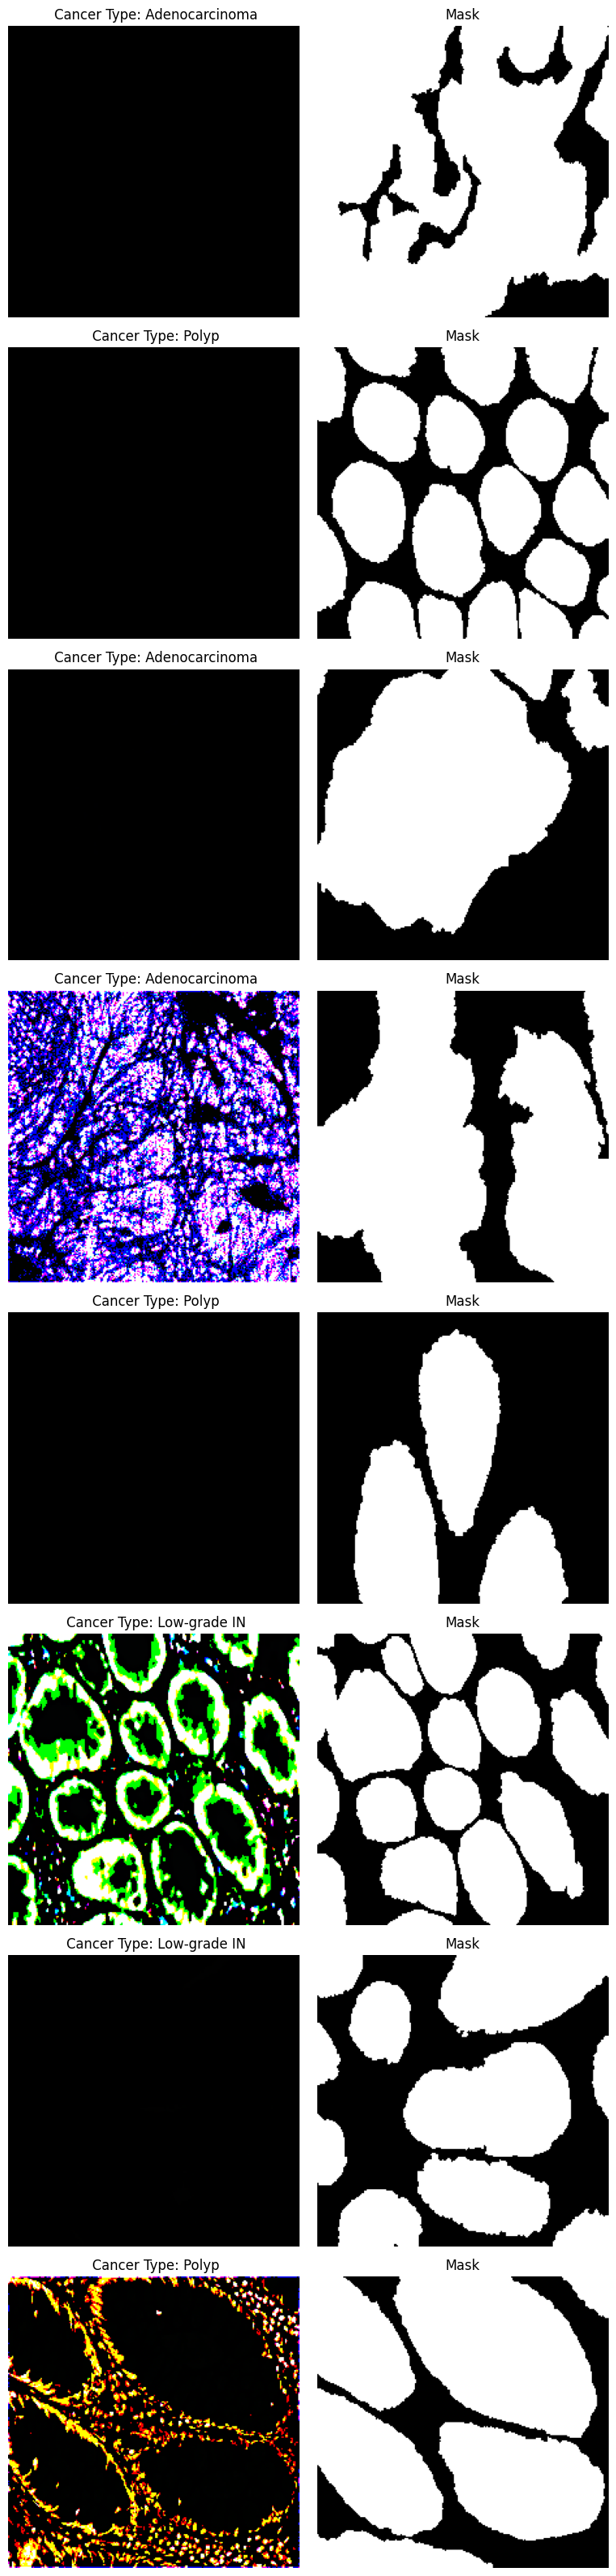

In [51]:
# Define the id2label dictionary
id2label = {0: 'Normal', 1: 'Polyp', 2: 'Low-grade IN', 3: 'Adenocarcinoma', 4: 'High-grade IN', 5: 'Serrated adenoma'}

# Assuming train_loader is your DataLoader
# Iterate over batches
for batch in train_loader:
    images, masks, labels = batch
    
    # Convert tensors to numpy arrays and reshape
    images = images.numpy().astype('uint8')
    masks = masks.numpy().astype('uint8')
    labels = labels.numpy()
    
    # Reshape images from (batch_size, channels, height, width) to (batch_size, height, width, channels)
    images = np.transpose(images, (0, 2, 3, 1))
    masks = np.transpose(masks, (0, 2, 3, 1))
    
    # Plot sample images and masks
    fig, axes = plt.subplots(nrows=len(images), ncols=2, figsize=(8, 32))
    for i in range(len(images)):
        label_name = id2label[labels[i]]
        axes[i, 0].imshow(images[i])
        axes[i, 0].set_title(f' Cancer Type: {label_name}')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(masks[i], cmap='gray')
        axes[i, 1].set_title('Mask')
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()
    break  # Only visualize the first batch

# The UNet Architecture

<img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png" 
     align="right" 
     width="1000"
     style="padding: 20px;" />
     
[UNet](https://arxiv.org/abs/1505.04597) is a deep learning neural network architecture originally designed for image segmentation tasks, but has since found use in GANs and latent diffusion models. Similar to autoencoders, the UNet structures include an encoder for compressing the input into a lower dimensional representation and a decoder for reconstructing the output from this compressed form. However, UNet distinguishes itself from autoencoders with several features:

- **Bottleneck**: At the centre of UNet is the bottleneck layer, situated between the encoder and decoder. This component captures the most abstract representation of the input.

- **Symmetrical Design**: The encoder and decoder parts of UNet are mirror images of each other. This symmetry facilitates the implementation of skip connections, which directly connect layers of the encoder to their corresponding layers in the decoder.

- **Skip Connections**: Unlike conventional autoencoders, UNet incorporates skip connections that can bypass the bottleneck, directly connecting the encoder to the decoder. These connections transfer contextual information from the spatially rich encoder, to the more feature heavy decoder, aiding in the precise localisation necessary for detailed segmentation.

In this project we're going to try different backbones for Unet including EfficientNet, VGG16, ResNet. We will also use UNet with attention and TransUNet.

In [38]:
# class EncoderBlock(nn.Module):
    
#     def __init__(self, in_channels, out_channels, activation=nn.ReLU()):
#         super().__init__()
#         self.encoder_block = nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), stride=1, padding=1),
#             activation,
#             nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), stride=1, padding=1),
#             activation
#         )
        
#     def forward(self, x):
#         return self.encoder_block(x)

# class DecoderBlock(nn.Module):
    
#     def __init__(self, in_channels, out_channels, activation=nn.ReLU()):
#         super().__init__()
#         self.decoder_block = nn.Sequential(
#             nn.Conv2d(in_channels, in_channels//2, kernel_size=(3, 3), stride=1, padding=1),
#             activation,
#             nn.Conv2d(in_channels//2, out_channels, kernel_size=(3, 3), stride=1, padding=1),
#             activation
#         )
    
#     def forward(self, x):
#         return self.decoder_block(x)
    
# class UNet(nn.Module):
#     def __init__(self):
#         super().__init__()

#         # Config
#         in_channels  = 3   # Input images have 3 channels
#         out_channels = 1   # Mask has 1 channel
#         n_filters    = 32  # Scaled down from 64 in original paper
#         activation   = nn.ReLU()

#         # Up and downsampling methods
#         self.downsample  = nn.MaxPool2d((2,2), stride=2)
#         self.upsample    = nn.UpsamplingBilinear2d(scale_factor=2)

#         # Encoder
#         self.enc_block_1 = EncoderBlock(in_channels, 1*n_filters, activation)
#         self.enc_block_2 = EncoderBlock(1*n_filters, 2*n_filters, activation)
#         self.enc_block_3 = EncoderBlock(2*n_filters, 4*n_filters, activation)
#         self.enc_block_4 = EncoderBlock(4*n_filters, 8*n_filters, activation)

#         # Bottleneck

#         self.bottleneck = nn.Sequential(
#             nn.Conv2d(8*n_filters, 16*n_filters, kernel_size=(3, 3), stride=1, padding=1),
#             activation,
#             nn.Conv2d(16*n_filters, 8*n_filters, kernel_size=(3, 3), stride=1, padding=1),
#             activation
#         )

#         # Decoder
#         self.dec_block_4 = DecoderBlock(16*n_filters, 4*n_filters, activation)
#         self.dec_block_3 = DecoderBlock(8*n_filters, 2*n_filters, activation)
#         self.dec_block_2 = DecoderBlock(4*n_filters, 1*n_filters, activation)
#         self.dec_block_1 = DecoderBlock(2*n_filters, 1*n_filters, activation)

#         # Output projection
#         self.output = nn.Conv2d(1*n_filters, out_channels, kernel_size=(1, 1), stride=1, padding=0)

#     def forward(self, x):

#         # Encoder
#         skip_1 = self.enc_block_1(x)
#         x      = self.downsample(skip_1)
#         skip_2 = self.enc_block_2(x)
#         x      = self.downsample(skip_2)
#         skip_3 = self.enc_block_3(x)
#         x      = self.downsample(skip_3)
#         skip_4 = self.enc_block_4(x)
#         x      = self.downsample(skip_4)

#         # Bottleneck
#         x      = self.bottleneck(x)

#         # Decoder
#         x      = self.upsample(x)
#         x      = torch.cat((x, skip_4), axis=1) # adding the skip connection
#         x      = self.dec_block_4(x)
#         x      = self.upsample(x)
#         x      = torch.cat((x, skip_3), axis=1)  # Skip connection
#         x      = self.dec_block_3(x)
#         x      = self.upsample(x)
#         x      = torch.cat((x, skip_2), axis=1)  # Skip connection
#         x      = self.dec_block_2(x)
#         x      = self.upsample(x)
#         x      = torch.cat((x, skip_1), axis=1)  # Skip connection
#         x      = self.dec_block_1(x)
#         x      = self.output(x)
#         return x
        
    
# # Function to count number of parameters in a model for comparisons later
# def count_parameters(model):
#     total_params = sum(p.numel() for p in model.parameters())
#     print(f'Total Parameters: {total_params:,}\n')

# # Function that saves a model to specified path
# def save_model(model, path='model_weights.pth'):
#     torch.save(model.state_dict(), path)

In [39]:
# class EncoderBlock(nn.Module):
    
#     def __init__(self, in_channels, out_channels, activation=nn.ReLU(), dropout_prob=0.0):
#         super().__init__()
#         self.encoder_block = nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), stride=1, padding=1),
#             nn.BatchNorm2d(out_channels),
#             activation,
#             nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), stride=1, padding=1),
#             nn.BatchNorm2d(out_channels),
#             activation,
#             nn.Dropout(dropout_prob)
#         )
        
#     def forward(self, x):
#         return self.encoder_block(x)

# class DecoderBlock(nn.Module):
    
#     def __init__(self, in_channels, out_channels, activation=nn.ReLU(), dropout_prob=0.0):
#         super().__init__()
#         self.decoder_block = nn.Sequential(
#             nn.Conv2d(in_channels, in_channels//2, kernel_size=(3, 3), stride=1, padding=1),
#             nn.BatchNorm2d(in_channels//2),
#             activation,
#             nn.Conv2d(in_channels//2, out_channels, kernel_size=(3, 3), stride=1, padding=1),
#             nn.BatchNorm2d(out_channels),
#             activation,
#             nn.Dropout(dropout_prob)
#         )
    
#     def forward(self, x):
#         return self.decoder_block(x)
    
# class UNet(nn.Module):
#     def __init__(self):
#         super().__init__()

#         # Config
#         in_channels  = 3   # Input images have 3 channels
#         out_channels = 1   # Mask has 1 channel
#         n_filters    = 32  # Reduced from 32 for smaller images
#         activation   = nn.ReLU()
#         dropout_prob = dropout # Dropout probability

#         # Up and downsampling methods
#         self.downsample  = nn.MaxPool2d((2,2), stride=2)
#         self.upsample    = nn.UpsamplingBilinear2d(scale_factor=2)

#         # Encoder
#         self.enc_block_1 = EncoderBlock(in_channels, 1*n_filters, activation, dropout_prob)
#         self.enc_block_2 = EncoderBlock(1*n_filters, 2*n_filters, activation, dropout_prob)
#         self.enc_block_3 = EncoderBlock(2*n_filters, 4*n_filters, activation, dropout_prob)
#         self.enc_block_4 = EncoderBlock(4*n_filters, 8*n_filters, activation, dropout_prob)

#         # Bottleneck
#         self.bottleneck = nn.Sequential(
#             nn.Conv2d(8*n_filters, 16*n_filters, kernel_size=(3, 3), stride=1, padding=1),
#             nn.BatchNorm2d(16*n_filters),
#             activation,
#             nn.Conv2d(16*n_filters, 8*n_filters, kernel_size=(3, 3), stride=1, padding=1),
#             nn.BatchNorm2d(8*n_filters),
#             activation,
#             nn.Dropout(dropout_prob)
#         )

#         # Decoder
#         self.dec_block_4 = DecoderBlock(16*n_filters, 4*n_filters, activation, dropout_prob)
#         self.dec_block_3 = DecoderBlock(8*n_filters, 2*n_filters, activation, dropout_prob)
#         self.dec_block_2 = DecoderBlock(4*n_filters, 1*n_filters, activation, dropout_prob)
#         self.dec_block_1 = DecoderBlock(2*n_filters, 1*n_filters, activation, dropout_prob)

#         # Output projection
#         self.output = nn.Conv2d(1*n_filters, out_channels, kernel_size=(1, 1), stride=1, padding=0)

#         # Initialize weights using Xavier initialization
#         self.initialize_weights()

#     def forward(self, x):

#         # Encoder
#         skip_1 = self.enc_block_1(x)
#         x      = self.downsample(skip_1)
#         skip_2 = self.enc_block_2(x)
#         x      = self.downsample(skip_2)
#         skip_3 = self.enc_block_3(x)
#         x      = self.downsample(skip_3)
#         skip_4 = self.enc_block_4(x)
#         x      = self.downsample(skip_4)

#         # Bottleneck
#         x      = self.bottleneck(x)

#         # Decoder
#         x      = self.upsample(x)
#         x      = torch.cat((x, skip_4), dim=1) # adding the skip connection
#         x      = self.dec_block_4(x)
#         x      = self.upsample(x)
#         x      = torch.cat((x, skip_3), dim=1)  # Skip connection
#         x      = self.dec_block_3(x)
#         x      = self.upsample(x)
#         x      = torch.cat((x, skip_2), dim=1)  # Skip connection
#         x      = self.dec_block_2(x)
#         x      = self.upsample(x)
#         x      = torch.cat((x, skip_1), dim=1)  # Skip connection
#         x      = self.dec_block_1(x)
#         x      = self.output(x)
#         return x
    
#     def initialize_weights(self):
#         for m in self.modules():
#             if isinstance(m, nn.Conv2d):
#                 nn.init.xavier_normal_(m.weight)
#                 if m.bias is not None:
#                     nn.init.constant_(m.bias, 0)
#             elif isinstance(m, nn.BatchNorm2d):
#                 nn.init.constant_(m.weight, 1)
#                 nn.init.constant_(m.bias, 0)

# # Function to count number of parameters in a model for comparisons later
# def count_parameters(model):
#     total_params = sum(p.numel() for p in model.parameters())
#     print(f'Total Parameters: {total_params:,}\n')

# # Function that saves a model to specified path
# def save_model(model, path='model_weights.pth'):
#     torch.save(model.state_dict(), path)

In [91]:
def build_model():
    model = smp.UnetPlusPlus(
        encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
        in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=CFG.num_classes,        # model output channels (number of classes in your dataset)
        decoder_use_batchnorm=True,
        decoder_attention_type=CFG.decoder_attention_type,
        activation=None,
#         aux_params=CFG.aux_params
    )
    model.to(CFG.device)
    return model

def load_model(path):
    model = build_model()
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

In [ ]:
# class EncoderBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, activation=nn.ReLU()):
#         super().__init__()
#         expansion_ratio = 4
        
#         self.encoder_block = nn.Sequential(
#             # ConvNeXt style blocks
#             nn.Conv2d(in_channels,                   in_channels, kernel_size=(7,7), stride=1, padding=3, groups=in_channels),
#             nn.BatchNorm2d(in_channels),
#             nn.Conv2d(in_channels,  expansion_ratio*out_channels, kernel_size=(1,1), stride=1),
#             activation,
#             nn.Conv2d(expansion_ratio*out_channels, out_channels, kernel_size=(1,1), stride=1),
            
#             nn.Conv2d(out_channels,                 out_channels, kernel_size=(7,7), stride=1, padding=3, groups=out_channels),
#             nn.BatchNorm2d(out_channels),
#             nn.Conv2d(out_channels, expansion_ratio*out_channels, kernel_size=(1,1), stride=1),
#             activation,
#             nn.Conv2d(expansion_ratio*out_channels, out_channels, kernel_size=(1,1), stride=1),
#         )
#     def forward(self, x):
#         return self.encoder_block(x)
    
    
# class DecoderBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, activation=nn.ReLU()):
#         super().__init__()
#         expansion_ratio = 4

#         self.decoder_block = nn.Sequential(
#             nn.Conv2d(in_channels,                    in_channels, kernel_size=(7,7), stride=1, padding=3, groups=in_channels),
#             nn.BatchNorm2d(in_channels),
#             nn.Conv2d(in_channels,    expansion_ratio*in_channels, kernel_size=(1,1), stride=1),
#             activation,
#             nn.Conv2d(expansion_ratio*in_channels,   out_channels, kernel_size=(1,1), stride=1),

#             nn.Conv2d(out_channels,                  out_channels, kernel_size=(7,7), stride=1, padding=3, groups=out_channels),
#             nn.BatchNorm2d(out_channels),
#             nn.Conv2d(out_channels,  expansion_ratio*out_channels, kernel_size=(1,1), stride=1),
#             activation,
#             nn.Conv2d(expansion_ratio*out_channels,  out_channels, kernel_size=(1,1), stride=1),
#         )
#     def forward(self, x):
#         return self.decoder_block(x)


# class UNet2(nn.Module):
#     def __init__(self):
#         super().__init__()
        
#         # Config
#         in_channels  = 4   # Input images have 4 channels
#         out_channels = 3   # Mask has 3 channels
#         n_filters    = 32  # Scaled down from 64 in original paper
#         activation   = nn.ReLU()
        
#         # Up and downsampling methods
#         self.downsample  = nn.MaxPool2d((2,2), stride=2)
#         self.upsample    = nn.UpsamplingBilinear2d(scale_factor=2)
        
#         # Encoder
#         self.enc_block_1 = EncoderBlock(in_channels, 1*n_filters, activation)
#         self.enc_block_2 = EncoderBlock(1*n_filters, 2*n_filters, activation)
#         self.enc_block_3 = EncoderBlock(2*n_filters, 4*n_filters, activation)
#         self.enc_block_4 = EncoderBlock(4*n_filters, 8*n_filters, activation)
        
#         # Bottleneck
#         self.bottleneck = nn.Sequential(
#             nn.Conv2d(     8*n_filters,   8*n_filters, kernel_size=(7,7), stride=1, padding=3, groups=8*n_filters),
#             nn.BatchNorm2d(8*n_filters),
#             nn.Conv2d(     8*n_filters, 4*8*n_filters, kernel_size=(1,1), stride=1),
#             activation,
#             nn.Conv2d(   4*8*n_filters,   8*n_filters, kernel_size=(1,1), stride=1),

#             nn.Conv2d(     8*n_filters,   8*n_filters, kernel_size=(7,7), stride=1, padding=3, groups=8*n_filters),
#             nn.BatchNorm2d(8*n_filters),
#             nn.Conv2d(     8*n_filters, 4*8*n_filters, kernel_size=(1,1), stride=1),
#             activation,
#             nn.Conv2d(   4*8*n_filters,   8*n_filters, kernel_size=(1,1), stride=1),
#         )
        
#         # Decoder
#         self.dec_block_4 = DecoderBlock(8*n_filters, 4*n_filters, activation)
#         self.dec_block_3 = DecoderBlock(4*n_filters, 2*n_filters, activation)
#         self.dec_block_2 = DecoderBlock(2*n_filters, 1*n_filters, activation)
#         self.dec_block_1 = DecoderBlock(1*n_filters, 1*n_filters, activation)
        
#         # Output projection
#         self.output      = nn.Conv2d(1*n_filters,  out_channels, kernel_size=(1,1), stride=1, padding=0)

#     def forward(self, x):
#         # Encoder
#         skip_1 = self.enc_block_1(x)
#         x      = self.downsample(skip_1)
#         skip_2 = self.enc_block_2(x)
#         x      = self.downsample(skip_2)
#         skip_3 = self.enc_block_3(x)
#         x      = self.downsample(skip_3)
#         skip_4 = self.enc_block_4(x)
#         x      = self.downsample(skip_4)
        
#         # Bottleneck
#         x      = self.bottleneck(x)
        
#         # Decoder
#         x      = self.upsample(x)
#         x      = torch.add(x, skip_4)  # Skip connection
#         x      = self.dec_block_4(x)
#         x      = self.upsample(x)
#         x      = torch.add(x, skip_3)  # Skip connection
#         x      = self.dec_block_3(x)
#         x      = self.upsample(x)
#         x      = torch.add(x, skip_2)  # Skip connection
#         x      = self.dec_block_2(x)
#         x      = self.upsample(x)
#         x      = torch.add(x, skip_1)  # Skip connection
#         x      = self.dec_block_1(x)
#         x      = self.output(x)
#         return x

In [92]:
# class EncoderBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, dropout_prob=0.0):
#         super().__init__()
#         self.encoder_block = nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), stride=1, padding=1),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), stride=1, padding=1),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True),
#             nn.Dropout(dropout_prob)
#         )
        
#     def forward(self, x):
#         return self.encoder_block(x)

# class DecoderBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, dropout_prob=0.0):
#         super().__init__()
#         self.decoder_block = nn.Sequential(
#             nn.Conv2d(in_channels, in_channels//2, kernel_size=(3, 3), stride=1, padding=1),
#             nn.BatchNorm2d(in_channels//2),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(in_channels//2, out_channels, kernel_size=(3, 3), stride=1, padding=1),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True),
#             nn.Dropout(dropout_prob)
#         )
    
#     def forward(self, x):
#         return self.decoder_block(x)
    
# class UNet(nn.Module):
#     def __init__(self, in_channels=3, out_channels=1, n_filters=32, dropout_prob=0.5):
#         super().__init__()

#         # Up and downsampling methods
#         self.downsample = nn.MaxPool2d((2,2), stride=2)
#         self.upsample = nn.UpsamplingBilinear2d(scale_factor=2)

#         # Encoder
#         self.enc_block_1 = EncoderBlock(in_channels, 1*n_filters, dropout_prob)
#         self.enc_block_2 = EncoderBlock(1*n_filters, 2*n_filters, dropout_prob)
#         self.enc_block_3 = EncoderBlock(2*n_filters, 4*n_filters, dropout_prob)
#         self.enc_block_4 = EncoderBlock(4*n_filters, 8*n_filters, dropout_prob)

#         # Bottleneck
#         self.bottleneck = nn.Sequential(
#             nn.Conv2d(8*n_filters, 16*n_filters, kernel_size=(3, 3), stride=1, padding=1),
#             nn.BatchNorm2d(16*n_filters),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(16*n_filters, 8*n_filters, kernel_size=(3, 3), stride=1, padding=1),
#             nn.BatchNorm2d(8*n_filters),
#             nn.ReLU(inplace=True),
#             nn.Dropout(dropout_prob)
#         )

#         # Decoder
#         self.dec_block_4 = DecoderBlock(16*n_filters, 4*n_filters, dropout_prob)
#         self.dec_block_3 = DecoderBlock(8*n_filters, 2*n_filters, dropout_prob)
#         self.dec_block_2 = DecoderBlock(4*n_filters, 1*n_filters, dropout_prob)
#         self.dec_block_1 = DecoderBlock(2*n_filters, 1*n_filters, dropout_prob)

#         # Output projection
#         self.output = nn.Conv2d(1*n_filters, out_channels, kernel_size=(1, 1), stride=1, padding=0)

#         # Initialize weights using Xavier initialization
#         self.initialize_weights()

#     def forward(self, x):
#         # Encoder
#         skip_1 = self.enc_block_1(x)
#         x      = self.downsample(skip_1)
#         skip_2 = self.enc_block_2(x)
#         x      = self.downsample(skip_2)
#         skip_3 = self.enc_block_3(x)
#         x      = self.downsample(skip_3)
#         skip_4 = self.enc_block_4(x)
#         x      = self.downsample(skip_4)

#         # Bottleneck
#         x = self.bottleneck(x)

#         # Decoder
#         x = self.upsample(x)
#         x = torch.cat((x, skip_4), dim=1)  # adding the skip connection
#         x = self.dec_block_4(x)
#         x = self.upsample(x)
#         x = torch.cat((x, skip_3), dim=1)  # Skip connection
#         x = self.dec_block_3(x)
#         x = self.upsample(x)
#         x = torch.cat((x, skip_2), dim=1)  # Skip connection
#         x = self.dec_block_2(x)
#         x = self.upsample(x)
#         x = torch.cat((x, skip_1), dim=1)  # Skip connection
#         x = self.dec_block_1(x)
#         x = self.output(x)
#         return x
    
#     def initialize_weights(self):
#         for m in self.modules():
#             if isinstance(m, nn.Conv2d):
#                 nn.init.xavier_normal_(m.weight)
#                 if m.bias is not None:
#                     nn.init.constant_(m.bias, 0)
#             elif isinstance(m, nn.BatchNorm2d):
#                 nn.init.constant_(m.weight, 1)
#                 nn.init.constant_(m.bias, 0)

# # Function to count number of parameters in a model for comparisons later
# def count_parameters(model):
#     total_params = sum(p.numel() for p in model.parameters())
#     print(f'Total Parameters: {total_params:,}\n')

# # # Function that saves a model to specified path
# # def save_model(model, path='model_weights.pth'):
# #     torch.save(model.state_dict(), path)

# Evaluation Metrics

In [93]:
class DiceLossImb(nn.Module):
    def __init__(self, smooth=1):
        super(DiceLossImb, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        # Ensure the sigmoid activation is applied to inputs if not included in model
        inputs = torch.sigmoid(inputs)

        # Flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        # Intersection is the sum of multiplied inputs and targets
        intersection = (inputs * targets).sum()
        
        # Calculate the Dice score with squared terms in the denominator
        dice_score = (2. * intersection + self.smooth) / (inputs.pow(2).sum() + targets.pow(2).sum() + self.smooth)
        
        # Dice loss is 1 minus the Dice score
        return 1 - dice_score

In [94]:
JaccardLoss = smp.losses.JaccardLoss(mode='binary')
# DiceLoss    = smp.losses.DiceLoss(mode='binary')
DiceLoss = DiceLossImb()
# BCELoss     = smp.losses.SoftBCEWithLogitsLoss()
BCELoss     = nn.BCEWithLogitsLoss()
LovaszLoss  = smp.losses.LovaszLoss(mode='binary', per_image=False)
TverskyLoss = smp.losses.TverskyLoss(mode='binary', log_loss=False)

def dice_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    intersection = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*intersection+epsilon)/(den+epsilon)).mean(dim=(1,0))
    return dice

def iou_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    intersection = (y_true*y_pred).sum(dim=dim)
    union = (y_true + y_pred - y_true*y_pred).sum(dim=dim)
    iou = ((intersection + epsilon) / (union + epsilon)).mean()  # Add epsilon to avoid division by zero 
    return iou

def criterion(y_true, y_pred):
#     return 0.5*BCELoss(y_pred, y_true) + 0.5*TverskyLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)

In [ ]:
# # Calculate the evaluation metrics

# def calculate_segmentation_metrics(predicted_mask, ground_truth_mask):
#     true_positive = np.logical_and(predicted_mask, ground_truth_mask).sum()
#     false_positive = np.logical_and(predicted_mask, np.logical_not(ground_truth_mask)).sum()
#     true_negative = np.logical_and(np.logical_not(predicted_mask), np.logical_not(ground_truth_mask)).sum()
#     false_negative = np.logical_and(np.logical_not(predicted_mask), ground_truth_mask).sum()

#     precision = true_positive / (true_positive + false_positive)
#     recall = true_positive / (true_positive + false_negative)
#     jaccard_similarity = true_positive / (true_positive + false_positive + false_negative)
#     dice_score = (2 * true_positive) / (2 * true_positive + false_positive + false_negative)
#     accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)

#     # print(true_positive)
#     # print(false_positive)
#     # print(true_negative)
#     # print(false_negative)

#     # print(precision)
#     # print(recall)
#     # print(jaccard_similarity)
#     # print(dice_score)
#     # print(accuracy)


#     return precision, recall, jaccard_similarity, dice_score, accuracy

In [95]:
# # testing iou function
# m = torch.ones(2, 3, 3)
# o = torch.randn(2, 3, 3)

# print(m)
# print(o)

# preds = torch.sigmoid(o) > 0.5
# print(torch.sigmoid(o))
# print(preds)
# intersection = torch.logical_and(preds > 0.5, m).sum(dim=(1, 2))
# print(intersection)
# union = torch.logical_or(preds > 0.5, m).sum(dim=(1, 2))
# print(union)
# iou = (intersection + 1e-7) / (union + 1e-7)  # Add epsilon to avoid division by zero
# avg_iou = iou.mean()
# avg_iou

In [96]:
# def train(dataset, dataloader, verbose=True):
    
#     model.train()
    
# #     n_epochs = config['n_epochs']
# #     learning_rate = config['learning_rate']
# #     lr_step_size = config['lr_step_size']
# #     lr_gamma = config['lr_gamma']
# #     momentum = config['momentum']
                      
# #     optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)    
# #     loss_fn = nn.BCEWithLogitsLoss()
    
# #     # learning rate scheduler: decreases learning rate of each parameter group by gamma every step_size
# #     scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_step_size, gamma=lr_gamma)
    
#     loss_sum = 0.0
#     iou_sum = 0
    

#     for batch_idx, (inputs, masks) in enumerate(dataloader):
    
#         inputs, masks = inputs.to(device, non_blocking=True), masks.to(device, non_blocking=True)
#         outputs = model(inputs)
        
#         batch_loss = loss_fn(outputs, masks)
#         optimizer.zero_grad()
#         batch_loss.backward()
#         optimizer.step()
#         # Calculate IoU for the batch
#         batch_iou = iou(outputs, masks)
#         loss_sum += batch_loss.item()
#         iou_sum += batch_iou.item()
        
#         if verbose: 
#             print(f'\rTrain batch: {batch_idx}, batch loss: {batch_loss}, batch IOU: {batch_iou*100}', end='')

# #     # step learning rate scheduler
# #     scheduler.step()

#     # Calculate average loss and IoU
#     avg_loss = loss_sum / len(dataloader)
#     avg_iou = iou_sum / len(dataloader)
    
#     return avg_loss, avg_iou

In [97]:
# o = torch.rand(2, 3, 3)
# c = torch.rand(2, 3, 3)
# print(o)
# print(c)
# # for output in o:
# #     print(output)
    
# m = torch.zeros(4, 3, 3, dtype=torch.float32)
# m[0] = o[0]
# m[1] = o[1]
# m[2] = c[0]
# m[3] = c[1]
# print(m)

In [98]:
# def train(config, model, train_dataloader, loss_fn, optimizer, scheduler):
#     model.train()
#     total_loss = 0.0
#     total_iou = 0.0

#     for batch_idx, (inputs, masks) in enumerate(train_dataloader):
#         inputs, masks = inputs.to(config['device']), masks.to(config['device'])
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = loss_fn(outputs, masks)
#         loss.backward()
#         optimizer.step()
#         batch_iou = iou(outputs, masks)

#         total_loss += loss.item()
#         total_iou += batch_iou.item()

#         if config['verbose']:
#             print(f'Train Batch {batch_idx+1}/{len(train_dataloader)} - Loss: {loss.item():.4f}, IoU: {batch_iou:.4f}')

#     scheduler.step()

#     return total_loss / len(train_dataloader), total_iou / len(train_dataloader)


# Train function

In [110]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    scaler = amp.GradScaler()
    
    dataset_size = 0
    running_loss = 0.0

    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Train ')
    for step, (inputs, masks, _) in pbar:
        inputs, masks = inputs.to(device, dtype=torch.float), masks.to(device, dtype=torch.float)
        
        batch_size = inputs.size(0)
        
        with amp.autocast(enabled=True):
            outputs = model(inputs)
            loss   = DiceLoss(outputs, masks)
            
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        
        if scheduler is not None:
            scheduler.step()

        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(train_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}',
                        gpu_mem=f'{mem:0.2f} GB')
    torch.cuda.empty_cache()
    gc.collect()

    return epoch_loss


In [100]:
# def test(dataset, dataloader):

#     # switch to test mode
#     model.eval()

#     # initialize predictions
#     pred_masks = torch.zeros(len(dataset), 224, 224, dtype=torch.float32)
#     sample_counter = 0
#     val_iou_sum = 0
#     # do not accumulate gradients (to make inference faster)
#     with torch.no_grad():
        
#         # test all batches
#         for (inputs, gt_masks) in dataloader:

#             # get data from dataloader [ignore labels/targets as they are not used in test mode]
#             inputs, gt_masks = inputs.to(device, non_blocking=True), gt_masks.to(device, non_blocking=True)

#             # forward pass
#             outputs = model(inputs)
            
#             # calculate IOU
#             batch_iou = iou(outputs, gt_masks)
#             val_iou_sum += batch_iou.item()
            
#             # Extract predictions from images
#             for output in outputs:
#                 pred_masks[sample_counter] = output
#                 sample_counter += 1

#     avg_val_iou = val_iou_sum / len(dataloader)
    
#     # return predictions
#     return pred_masks, avg_val_iou

# Validation function

In [111]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    val_scores = []
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Valid ')
    for step, (inputs, masks, _) in pbar:
        inputs, masks,  = inputs.to(device, dtype=torch.float), masks.to(device, dtype=torch.float)
        
        batch_size = inputs.size(0)
        
        outputs  = model(inputs)
        loss = DiceLoss(outputs, masks)
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        y_pred = nn.Sigmoid()(outputs)
        val_dice = dice_coef(masks, y_pred).cpu().detach().numpy()
        val_jaccard = iou_coef(masks, y_pred).cpu().detach().numpy()
        val_scores.append([val_dice, val_jaccard])
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(valid_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}',
                        gpu_memory=f'{mem:0.2f} GB')
    val_scores  = np.mean(val_scores, axis=0)
    torch.cuda.empty_cache()
    gc.collect()
    
    return epoch_loss, val_scores

In [112]:
# def test(config, model, dataloader):
#     model.eval()
#     total_iou = 0.0
#     with torch.no_grad():
#         for inputs, masks in dataloader:
#             inputs, masks = inputs.to(config['device']), masks.to(config['device'])
#             outputs = model(inputs)
#             total_iou += iou(outputs, masks).item()

#     return total_iou / len(dataloader)

# Building blocks for training

In [113]:
# # Create UNet model and count params
# model = UNet()
# count_parameters(model)

# # loss function: 
# loss_fn = nn.BCEWithLogitsLoss()

# # SGD optimizer: stochastic gradient descent
# optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

# # learning rate scheduler: decreases learning rate of each parameter group by gamma every step_size
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_step_size, gamma=lr_gamma)

## Run Training 

The code in the cell below defines and executes the training function for our UNet models. 

The training process involves:
- Setting up the model and training configuration.
- Initialising the model and moving it to the chosen device.
- Adam optimizer for parameter updates and binary cross-entropy loss as the loss function.
- We then iterate through each epoch, we can optionally dynamically adjust the learning rate.

For each epoch, we conduct both training and validation steps:
- In the training step, we feed batches of data to the model, computes the loss, and updates the model parameters.
- In the validation step, we evaluate the model on a separate dataset to monitor performance without updating model parameters.
- We track and print out the average training and validation losses for each epoch, providing insights into the model's learning progress.

Finally, the function returns lists of training and validation losses for further analysis or plotting.

In [114]:
# # train_model TRUE -> TRAIN MODEL
# if train_model:
    
# #     # Settings for training
# #     train_config = {
# #         'device':            device,
# #         'n_epochs':          n_epochs,
# #         'learning_rate':     learning_rate,
# #         'lr_step_size':      lr_step_size,
# #         'lr_gamma':          lr_gamma,
# #         'momentum':          momentum
# #     }
    
#     # init performance monitors
#     losses = []
#     train_ious = []
#     valid_ious = []
#     ticks = []
    
#     # move model to gpu
#     model.to(device)
#     # start training
#     for epoch in range(1, n_epochs+1):

#         # measure time elapsed
#         t0 = time.time()

#         # TRAIN
#         avg_loss, avg_iou_train = train(train_dataset, train_dataloader)

#         # TEST on validation set
#         prediction_masks, validation_iou = test(val_dataset, val_dataloader)
        
#         # step learning rate scheduler
#         scheduler.step()
        
#         # update performance history
#         losses.append(avg_loss)
#         train_ious.append(avg_iou_train)
#         valid_ious.append(validation_iou)
#         ticks.append(epoch)

#         # PERFORMANCE
#         if print_performance:
#             # Print Performance
#             print ("\nEPOCH %d\n"
#                 "TIME: %.1f seconds\n"
#                 "LOSS: %g (best %g at epoch %d)\n"
#                 "TRAINING IOU: %.2f%% (best %.2f%% at epoch %d)\n"
#                 "VALIDATION IOU: %.2f%% (best %.2f%% at epoch %d)" % (
#                 epoch,
#                 time.time()-t0,
#                 avg_loss, min(losses), ticks[np.argmin(losses)],
#                 avg_iou_train*100, max(train_ious)*100, ticks[np.argmax(train_ious*100)],
#                 validation_iou*100, max(valid_ious)*100, ticks[np.argmax(valid_ious*100)]))
            
#         if display_performance:
#             # Display Performance
#             fig, ax1 = plt.subplots(figsize=(12, 8), num=1)
#             ax1.set_xticks(np.arange(0, n_epochs+1, step=n_epochs/10.0))
#             ax1.set_xlabel('Epochs')
#             ax1.set_ylabel(type(loss_fn).__name__, color='blue')
#             ax1.set_ylim(0.0001, 1)
#             ax1.tick_params(axis='y', labelcolor='blue')
#             ax1.set_yscale('log')
#             ax1.plot(ticks, losses, 'b-', linewidth=1.0, aa=True,
#                 label='Training (best at ep. %d)' % ticks[np.argmin(losses)])
#             ax1.legend(loc="lower left")
#             ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
#             ax2.set_ylabel('IOU %', color='red')
#             ax2.set_ylim(0.5, 1.0)
#             ax2.set_yticks(np.arange(0.5, 1.0, step=0.05))
#             ax2.tick_params(axis='y', labelcolor='red')
#             ax2.plot(ticks, train_ious, 'r-', linewidth=1.0, aa=True,
#                 label='Training (%.2f%%, best %.2f%% at ep. %d)' % (avg_iou_train, max(train_ious), ticks[np.argmax(train_ious)]))
#             ax2.plot(ticks, valid_ious, 'r--', linewidth=1.0, aa=True,
#                 label='Validation (%.2f%%, best %.2f%% at ep. %d)' % (validation_iou, max(valid_ious), ticks[np.argmax(valid_ious)]))
#             ax2.legend(loc="lower right")
#             plt.xlim(0, n_epochs+1)

#             plt.draw()
#             #plt.pause(0.001)
#             plt.show()
#             fig.clear()
            
#         # save model if validation performance has improved
#         if (epoch-1) == np.argmax(valid_ious):
#             torch.save({
#                 'model': model,
#                 'IOU': max(valid_ious),
#                 'epoch': epoch
#             }, experiment_ID + ".tar")
            
#     # Display Final Performance
#     print ("\n\n")
#     print ("==================\n")
#     print ("FINAL PERFORMANCE \n")
#     print ("==================\n")

#     fig, ax1 = plt.subplots(figsize=(12, 8), num=1)
#     ax1.set_xticks(np.arange(0, n_epochs+1, step=n_epochs/10.0))
#     ax1.set_xlabel('Epochs')
#     ax1.set_ylabel(type(loss_fn).__name__, color='blue')
#     ax1.set_ylim(0.0001, 1)
#     ax1.tick_params(axis='y', labelcolor='blue')
#     ax1.set_yscale('log')
#     ax1.plot(ticks, losses, 'b-', linewidth=1.0, aa=True,
#         label='Training (best at ep. %d)' % ticks[np.argmin(losses)])
#     ax1.legend(loc="lower left")
#     ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
#     ax2.set_ylabel('IOU %', color='red')
#     ax2.set_ylim(0.5, 1.0)
#     ax2.set_yticks(np.arange(.5, 1.0, step=.05))
#     ax2.tick_params(axis='y', labelcolor='red')
#     ax2.plot(ticks, train_ious, 'r-', linewidth=1.0, aa=True,
#         label='Training (%.2f%%, best %.2f%% at ep. %d)' % (avg_iou_train, max(train_ious), ticks[np.argmax(train_ious)]))
#     ax2.plot(ticks, valid_ious, 'r--', linewidth=1.0, aa=True,
#         label='Validation (%.2f%%, best %.2f%% at ep. %d)' % (validation_iou, max(valid_ious), ticks[np.argmax(valid_ious)]))
#     ax2.legend(loc="lower right")
#     plt.xlim(0, n_epochs+1)

#     plt.draw()
#     #plt.pause(0.001)
#     plt.savefig(experiment_ID + ".png", dpi=300)
#     plt.show()
#     fig.clear()
    
# # train_model FALSE -> TEST MODEL
# else:

#     # LOAD PRETRAINED MODEL
#     checkpoint = torch.load(experiment_ID + ".tar", map_location=lambda storage, loc: storage)
#     model = checkpoint['model']
#     print ("LOADED PRETRAINED MODEL\n")
#     print ("(Trained for %d epochs\n IOU: %.2f)" % (checkpoint['epoch'], checkpoint['IOU']))

#     # move model to device
#     model.to(device)

#     # TEST
#     predictions = test(dataset_valid, dataloader_valid)
#     accuracy = 100. * predictions.eq(dataset_valid.targets).sum().float() / len(dataset_valid)
#     print ("ACCURACY ON TEST SET IS: %.2f" % accuracy)

#     # DISPLAY ERRORS
#     if display_errors:

#         # predictions / target comparisons = 1 for match, 0 for mismatch
#         # we subtract 1, so we have 0 for match, -1 for mismatch
#         # nonzero elements are thus all mismatches
#         errors = torch.nonzero(torch.logical_not(predictions.eq(dataset_valid.targets)))

#         print ('\nNUMBER OF ERRORS:', len(errors))

#         # get errors samples and convert them to torch tensors
#         error_samples = torch.zeros(len(errors), 1, 28, 28)
#         conversion = Convert()
#         for i, e in enumerate(errors):
#             error_samples[i] = conversion(dataset_valid.data[e.item()])

#         # make a grid of images and show
#         img = torchvision.utils.make_grid(error_samples, nrow=20)
#         img = img/255       # move data to [0,1] since pyplot expects float images to be in [0,1]
#         npimg = img.numpy() # convert to numpy, since pyplot expects numpy images
#         plt.imshow(np.transpose(npimg, (1, 2, 0)))  # CHW to WHC reshape
#         plt.title('Errors')
#         plt.savefig("Errors" + ".png", dpi=300)
#         plt.show()



In [115]:
# def run_training(model, optimizer, scheduler, device, num_epochs):
#     # To automatically log gradients
#     wandb.watch(model, log_freq=100)
    
#     if torch.cuda.is_available():
#         print("cuda: {}\n".format(torch.cuda.get_device_name()))
        
#     start = time.time()
#     best_model_wts = copy.deepcopy(model.state_dict())
#     best_dice      = -np.inf
#     best_epoch     = -1
#     history = defaultdict(list)
    
#     for epoch in range(1, num_epochs + 1):
#         gc.collect()
#         print(f'Epoch {epoch}/{num_epochs}', end='')
#         train_loss = train_one_epoch(model, optimizer, scheduler, 
#                                            dataloader=train_loader, 
#                                            device=CFG.device, epoch=epoch)
        
#         val_loss, val_scores = valid_one_epoch(model, valid_loader, 
#                                                  device=CFG.device, 
#                                                  epoch=epoch)
        
#         val_dice, val_jaccard = val_scores
        
#         history['Train Loss'].append(train_loss)
#         history['Valid Loss'].append(val_loss)
#         history['Valid Dice'].append(val_dice)
#         history['Valid Jaccard'].append(val_jaccard)
        
#         # Log the metrics
#         wandb.log({"Train Loss": train_loss, 
#                    "Valid Loss": val_loss,
#                    "Valid Dice": val_dice,
#                    "Valid Jaccard": val_jaccard,
#                    "LR":scheduler.get_last_lr()[0]})
        
#         print(f'Valid Dice: {val_dice:0.4f} | Valid Jaccard: {val_jaccard:0.4f}')
        
#         # deepcopy the model
#         if val_dice >= best_dice:
#             print(f"{c_}Valid Score Improved ({best_dice:0.4f} ---> {val_dice:0.4f})")
#             best_dice    = val_dice
#             best_jaccard = val_jaccard
#             best_epoch   = epoch
#             run.summary["Best Dice"]    = best_dice
#             run.summary["Best Jaccard"] = best_jaccard
#             run.summary["Best Epoch"]   = best_epoch
#             best_model_wts = copy.deepcopy(model.state_dict())
#             PATH = f"best_epoch-{fold:02d}.bin"
#             torch.save(model.state_dict(), PATH)
#             # Save a model file from the current directory
#             wandb.save(PATH)
#             print(f"Model Saved{sr_}")
            
#         last_model_wts = copy.deepcopy(model.state_dict())
#         PATH = f"last_epoch-{fold:02d}.bin"
#         torch.save(model.state_dict(), PATH)
            
#         print(); print()
        
#     end = time.time()
#     time_elapsed = end - start
#     print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
#         time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
#     print("Best Score: {:.4f}".format(best_jaccard))
    
#     # load best model weights
#     model.load_state_dict(best_model_wts)
    
#     return model, history

In [ ]:
# def should_switch_scheduler(epoch, val_loss, best_val_loss, switch_patience=5):
#     """Decide whether to switch the learning rate scheduler."""
#     if val_loss > best_val_loss:
#         return epoch >= switch_patience
#     return False

In [ ]:
def dynamic_switch_epoch(val_losses, patience=5, min_delta=0.01):
    """
    Determines the epoch to switch the learning rate scheduler based on validation loss improvements.
    
    Args:
    - val_losses (list): List of validation losses recorded at the end of each epoch.
    - patience (int): Number of epochs to wait for an improvement before switching.
    - min_delta (float): Minimum change in the monitored quantity to qualify as an improvement.
    
    Returns:
    - switch_epoch (int or None): The epoch at which to switch the scheduler, or None if no switch is needed yet.
    """
    if len(val_losses) < patience:
        return None
    
    for i in range(patience):
        if val_losses[-(i+1)] < min(val_losses[:-patience]):
            return None
    
    return len(val_losses)


`dynamic_switch_epoch Function`
This function takes into account the history of validation losses and determines if the switch should occur based on a series of conditions over multiple epochs:

- Purpose: To provide a more nuanced and dynamic decision on when to switch the learning rate scheduler based on the history of validation losses.
- Logic:
    - It checks if the validation losses over a specified number of recent epochs (patience) have shown sufficient improvement.
    - If the validation loss has not improved over the defined patience period, it triggers the scheduler switch.
    - This method is more robust as it considers the overall trend in validation performance rather than a single comparison.

In [ ]:
def run_training(model, optimizer, scheduler, device, num_epochs, train_loader, valid_loader, switch_patience=5, min_delta=0.01):
    # To automatically log gradients
    wandb.watch(model, log_freq=100)
    
    if torch.cuda.is_available():
        print("cuda: {}\n".format(torch.cuda.get_device_name()))
        
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_dice = -np.inf
    best_epoch = -1
    best_val_loss = np.inf
    history = defaultdict(list)
    early_stopping = EarlyStopping(patience=5)
    
    scheduler = fetch_scheduler(optimizer, epoch=0, switch_epoch=num_epochs)  # Start with initial scheduler
    
    val_losses = []
    dynamic_switch_done = False  # Initialize to indicate that the switch has not been done
    
    for epoch in range(1, num_epochs + 1):
        gc.collect()
        print(f'Epoch {epoch}/{num_epochs}', end='')
        
        train_loss = train_one_epoch(model, optimizer, scheduler, 
                                     dataloader=train_loader, 
                                     device=device, epoch=epoch)
        
        val_loss, val_scores = valid_one_epoch(model, valid_loader, 
                                               device=device, 
                                               epoch=epoch)
        
        val_dice, val_jaccard = val_scores
        
        history['Train Loss'].append(train_loss)
        history['Valid Loss'].append(val_loss)
        history['Valid Dice'].append(val_dice)
        history['Valid Jaccard'].append(val_jaccard)
        
        # Log the metrics
        wandb.log({"Train Loss": train_loss, 
                   "Valid Loss": val_loss,
                   "Valid Dice": val_dice,
                   "Valid Jaccard": val_jaccard,
                   "LR": scheduler.get_last_lr()[0]})
        
        print(f'Valid Dice: {val_dice:0.4f} | Valid Jaccard: {val_jaccard:0.4f}')
        
        # Update best validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
        
        val_losses.append(val_loss)
        
        # Decide whether to switch scheduler dynamically
        if not dynamic_switch_done:  # Check if the switch has not been done
            switch_epoch = dynamic_switch_epoch(val_losses, patience=switch_patience, min_delta=min_delta)
            if switch_epoch:
                print(f"Switching scheduler at epoch {switch_epoch}")
                scheduler = fetch_scheduler(optimizer, epoch, switch_epoch)
                dynamic_switch_done = True  # Set to True to indicate that the switch is done
        
        # Early stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
        # Deepcopy the model
        if val_dice >= best_dice:
            print(f"Valid Score Improved ({best_dice:0.4f} ---> {val_dice:0.4f})")
            best_dice = val_dice
            best_jaccard = val_jaccard
            best_epoch = epoch
            run.summary["Best Dice"] = best_dice
            run.summary["Best Jaccard"] = best_jaccard
            run.summary["Best Epoch"] = best_epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"best_epoch-{epoch:02d}.bin"
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            wandb.save(PATH)
            print(f"Model Saved")
            
        last_model_wts = copy.deepcopy(model.state_dict())
        PATH = f"last_epoch-{epoch:02d}.bin"
        torch.save(model.state_dict(), PATH)
            
        print(); print()
        
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Score: {:.4f}".format(best_jaccard))
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    
    history['Best Dice'] = best_dice
    history['Best Jaccard'] = best_jaccard
    history['Best Epoch'] = best_epoch

    return model, history

# Optimizer

In [1]:
def fetch_scheduler(optimizer, epoch, switch_epoch):
    
    # Define the initial scheduler
    if epoch < switch_epoch:
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, eta_min=CFG.min_lr)
        
    # Define the scheduler after the switch epoch
    else:
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, threshold=0.0001, min_lr=CFG.min_lr)
    
    return scheduler

In [116]:
# def fetch_scheduler(optimizer):
#     if CFG.scheduler == 'CosineAnnealingLR':
#         scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CFG.T_max, 
#                                                    eta_min=CFG.min_lr)
#     elif CFG.scheduler == 'CosineAnnealingWarmRestarts':
#         scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CFG.T_0, 
#                                                              eta_min=CFG.min_lr)
#     elif CFG.scheduler == 'ReduceLROnPlateau':
#         scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,
#                                                    mode='min',
#                                                    factor=0.1,
#                                                    patience=7,
#                                                    threshold=0.0001,
#                                                    min_lr=CFG.min_lr,)
#     elif CFG.scheduer == 'ExponentialLR':
#         scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.85)
#     elif CFG.scheduler == None:
#         return None
        
#     return scheduler

In [107]:
# model = UNet().to(CFG.device)
model = build_model()
optimizer = optim.Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.wd)
scheduler = fetch_scheduler(optimizer)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b1-f1951068.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 185MB/s]


In [108]:
# writer = SummaryWriter()

# try:
#     # Model
#     model = UNet().to(config['device'])
#     optimizer = Adam(model.parameters(), lr=config['learning_rate'])
#     scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)
#     loss_fn = nn.BCEWithLogitsLoss()

#     for epoch in range(config['n_epochs']):
#         avg_loss, avg_iou = train(config, model, train_dataloader, loss_fn, optimizer, scheduler)
#         val_iou = test(config, model, val_dataloader)

#         writer.add_scalar('Loss/train', avg_loss, epoch)
#         writer.add_scalar('IoU/train', avg_iou, epoch)
#         writer.add_scalar('IoU/val', val_iou, epoch)

#         print(f'Epoch {epoch+1}: Avg Training Loss: {avg_loss:.4f}, Avg Training IoU: {avg_iou:.4f}, Validation IoU: {val_iou:.4f}')

# except Exception as e:
#     print(f'An error occurred: {e}')
# finally:
#     torch.cuda.empty_cache()
#     writer.close()


# Training

In [ ]:
import torch.optim.lr_scheduler as lr_scheduler

def fetch_scheduler(optimizer, epoch, val_loss, best_val_loss, switch_epoch):
    # Before the switch epoch
    if epoch < switch_epoch:
        if CFG.scheduler == 'CosineAnnealingWarmRestarts':
            scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, 
                                                                 eta_min=CFG.min_lr)
        elif CFG.scheduler == 'ReduceLROnPlateau':
            scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       mode='min',
                                                       factor=0.1,
                                                       patience=7,
                                                       threshold=0.0001,
                                                       min_lr=CFG.min_lr)
        elif CFG.scheduler == 'ExponentialLR':
            scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.85)
        else:  # Default to CosineAnnealingLR
            scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=CFG.T_max, 
                                                       eta_min=CFG.min_lr)
    # After the switch epoch
    else:
        if val_loss > best_val_loss:
            scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       mode='min',
                                                       factor=0.1,
                                                       patience=5,
                                                       threshold=0.0001,
                                                       min_lr=CFG.min_lr)
        else:
            scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=CFG.T_max, 
                                                       eta_min=CFG.min_lr)
    
    return scheduler


In [ ]:
best_overall_dice = -np.inf
best_overall_model_wts = None

for fold in range(2):
    print(f'#'*15)
    print(f'### Fold: {fold}')
    print(f'#'*15)
    run = wandb.init(project='cct-seg-unicas', 
                     config={k:v for k, v in dict(vars(CFG)).items() if '__' not in k},
                     anonymous=anonymous,
                     name=f"fold-{fold}|dim-{CFG.img_size[0]}x{CFG.img_size[1]}|model-{CFG.model_name}|attention-{CFG.decoder_attention_type}|batch_norm-True|batchsize-8|augmentation-weighted_sampling",
                     group=CFG.comment,
                    )
    train_loader, valid_loader = prepare_loaders(fold=fold, num_augmented_images=250, num_copies=2, debug=CFG.debug)
    model = build_model()
    optimizer = optim.Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.wd)
    
    # Note: Scheduler is now set within run_training based on dynamic switch logic
    model, history = run_training(model, optimizer, scheduler=None,
                                  device=CFG.device,
                                  num_epochs=CFG.epochs,
                                  train_loader=train_loader,
                                  valid_loader=valid_loader,
                                  switch_patience=5)  # Adjust patience as needed
    
    # Update overall best model
    if history['Best Dice'] > best_overall_dice:
        best_overall_dice = history['Best Dice']
        best_overall_model_wts = copy.deepcopy(model.state_dict())
    
    run.finish()
    display(ipd.IFrame(run.url, width=1000, height=720))

# Save the best overall model weights
if best_overall_model_wts is not None:
    torch.save(best_overall_model_wts, f"best_model_overall.bin")
    print(f"Best overall model saved with dice score: {best_overall_dice:.4f}")
else:
    print("No best model weights to save.")

In [132]:
# for fold in range(2):
#     print(f'#'*15)
#     print(f'### Fold: {fold}')
#     print(f'#'*15)
#     run = wandb.init(project='cct-seg-unicas', 
#                      config={k:v for k, v in dict(vars(CFG)).items() if '__' not in k},
#                      anonymous=anonymous,
#                      name=f"fold-{fold}|dim-{CFG.img_size[0]}x{CFG.img_size[1]}|model-{CFG.model_name}|attention-{CFG.decoder_attention_type}|batch_norm-True|batchsize-8|augmentation-weighted_sampling",
#                      group=CFG.comment,
#                     )
#     train_loader, valid_loader = prepare_loaders(fold=fold, num_augmented_images=250, num_copies=2, debug=CFG.debug)
# #     model     = UNet().to(CFG.device)
#     model = build_model()
#     optimizer = optim.Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.wd)
#     scheduler = fetch_scheduler(optimizer)
#     model, history = run_training(model, optimizer, scheduler,
#                                   device=CFG.device,
#                                   num_epochs=CFG.epochs)
#     run.finish()
#     display(ipd.IFrame(run.url, width=1000, height=720))

###############
### Fold: 0
###############


cuda: Tesla P100-PCIE-16GB

Epoch 1/30

Valid : 100%|██████████| 2/2 [00:04<00:00,  2.05s/it, gpu_memory=15.42 GB, lr=0.00010, valid_loss=0.0525]


Valid Dice: 0.9322 | Valid Jaccard: 0.8772
Valid Score Improved (-inf ---> 0.9322)
Model Saved


Epoch 2/30

Valid : 100%|██████████| 2/2 [00:04<00:00,  2.02s/it, gpu_memory=15.43 GB, lr=0.00035, valid_loss=0.0507]


Valid Dice: 0.9357 | Valid Jaccard: 0.8854
Valid Score Improved (0.9322 ---> 0.9357)
Model Saved


Epoch 3/30

Valid : 100%|██████████| 2/2 [00:03<00:00,  1.95s/it, gpu_memory=15.45 GB, lr=0.00065, valid_loss=0.0417]


Valid Dice: 0.9440 | Valid Jaccard: 0.8981
Valid Score Improved (0.9357 ---> 0.9440)
Model Saved


Epoch 4/30

Valid : 100%|██████████| 2/2 [00:03<00:00,  1.95s/it, gpu_memory=15.45 GB, lr=0.00090, valid_loss=0.0425]


Valid Dice: 0.9431 | Valid Jaccard: 0.8973


Epoch 5/30

Valid : 100%|██████████| 2/2 [00:04<00:00,  2.07s/it, gpu_memory=15.43 GB, lr=0.00100, valid_loss=0.0425]


Valid Dice: 0.9439 | Valid Jaccard: 0.8984


Epoch 6/30

Valid : 100%|██████████| 2/2 [00:04<00:00,  2.06s/it, gpu_memory=15.45 GB, lr=0.00010, valid_loss=0.0414]


Valid Dice: 0.9447 | Valid Jaccard: 0.8990
Valid Score Improved (0.9440 ---> 0.9447)
Model Saved


Epoch 7/30

Valid : 100%|██████████| 2/2 [00:03<00:00,  1.98s/it, gpu_memory=15.43 GB, lr=0.00035, valid_loss=0.0400]


Valid Dice: 0.9460 | Valid Jaccard: 0.9017
Valid Score Improved (0.9447 ---> 0.9460)
Model Saved


Epoch 8/30

Valid : 100%|██████████| 2/2 [00:04<00:00,  2.01s/it, gpu_memory=15.45 GB, lr=0.00065, valid_loss=0.0435]


Valid Dice: 0.9428 | Valid Jaccard: 0.8960


Epoch 9/30

Valid : 100%|██████████| 2/2 [00:04<00:00,  2.14s/it, gpu_memory=15.45 GB, lr=0.00090, valid_loss=0.0411]


Valid Dice: 0.9463 | Valid Jaccard: 0.9019
Valid Score Improved (0.9460 ---> 0.9463)
Model Saved


Epoch 10/30

Valid : 100%|██████████| 2/2 [00:03<00:00,  1.96s/it, gpu_memory=15.45 GB, lr=0.00100, valid_loss=0.0441]


Valid Dice: 0.9423 | Valid Jaccard: 0.8962


Epoch 11/30

Valid : 100%|██████████| 2/2 [00:04<00:00,  2.01s/it, gpu_memory=15.44 GB, lr=0.00010, valid_loss=0.0410]


Valid Dice: 0.9466 | Valid Jaccard: 0.9028
Valid Score Improved (0.9463 ---> 0.9466)
Model Saved


Epoch 12/30

Valid : 100%|██████████| 2/2 [00:03<00:00,  2.00s/it, gpu_memory=15.45 GB, lr=0.00035, valid_loss=0.0414]


Valid Dice: 0.9453 | Valid Jaccard: 0.9001


Epoch 13/30

Valid : 100%|██████████| 2/2 [00:04<00:00,  2.04s/it, gpu_memory=15.45 GB, lr=0.00065, valid_loss=0.0403]


Valid Dice: 0.9467 | Valid Jaccard: 0.9029
Valid Score Improved (0.9466 ---> 0.9467)
Model Saved


Epoch 14/30

Valid : 100%|██████████| 2/2 [00:04<00:00,  2.07s/it, gpu_memory=15.45 GB, lr=0.00090, valid_loss=0.0396]


Valid Dice: 0.9483 | Valid Jaccard: 0.9054
Valid Score Improved (0.9467 ---> 0.9483)
Model Saved


Epoch 15/30

Valid : 100%|██████████| 2/2 [00:03<00:00,  1.99s/it, gpu_memory=15.44 GB, lr=0.00100, valid_loss=0.0396]


Valid Dice: 0.9489 | Valid Jaccard: 0.9062
Valid Score Improved (0.9483 ---> 0.9489)
Model Saved


Epoch 16/30

Valid : 100%|██████████| 2/2 [00:03<00:00,  1.95s/it, gpu_memory=15.45 GB, lr=0.00010, valid_loss=0.0421]


Valid Dice: 0.9464 | Valid Jaccard: 0.9030


Epoch 17/30

Valid : 100%|██████████| 2/2 [00:04<00:00,  2.20s/it, gpu_memory=15.45 GB, lr=0.00035, valid_loss=0.0452]


Valid Dice: 0.9423 | Valid Jaccard: 0.8971


Epoch 18/30

Valid : 100%|██████████| 2/2 [00:03<00:00,  1.97s/it, gpu_memory=15.45 GB, lr=0.00065, valid_loss=0.0392]


Valid Dice: 0.9487 | Valid Jaccard: 0.9061


Epoch 19/30

Valid : 100%|██████████| 2/2 [00:03<00:00,  1.99s/it, gpu_memory=15.45 GB, lr=0.00090, valid_loss=0.0398]


Valid Dice: 0.9480 | Valid Jaccard: 0.9049


Epoch 20/30

Valid : 100%|██████████| 2/2 [00:04<00:00,  2.04s/it, gpu_memory=15.45 GB, lr=0.00100, valid_loss=0.0394]


Valid Dice: 0.9489 | Valid Jaccard: 0.9067


Epoch 21/30

Valid : 100%|██████████| 2/2 [00:03<00:00,  1.99s/it, gpu_memory=15.45 GB, lr=0.00010, valid_loss=0.0387]


Valid Dice: 0.9497 | Valid Jaccard: 0.9079
Valid Score Improved (0.9489 ---> 0.9497)
Model Saved


Epoch 22/30

Valid : 100%|██████████| 2/2 [00:04<00:00,  2.13s/it, gpu_memory=15.45 GB, lr=0.00035, valid_loss=0.0388]


Valid Dice: 0.9498 | Valid Jaccard: 0.9077
Valid Score Improved (0.9497 ---> 0.9498)
Model Saved


Epoch 23/30

Valid : 100%|██████████| 2/2 [00:04<00:00,  2.05s/it, gpu_memory=15.44 GB, lr=0.00065, valid_loss=0.0394]


Valid Dice: 0.9490 | Valid Jaccard: 0.9067


Epoch 24/30

Valid : 100%|██████████| 2/2 [00:04<00:00,  2.01s/it, gpu_memory=15.45 GB, lr=0.00090, valid_loss=0.0388]


Valid Dice: 0.9499 | Valid Jaccard: 0.9081
Valid Score Improved (0.9498 ---> 0.9499)
Model Saved


Epoch 25/30

Valid : 100%|██████████| 2/2 [00:04<00:00,  2.00s/it, gpu_memory=15.44 GB, lr=0.00100, valid_loss=0.0389]


Valid Dice: 0.9492 | Valid Jaccard: 0.9071


Epoch 26/30

Valid : 100%|██████████| 2/2 [00:03<00:00,  1.96s/it, gpu_memory=15.45 GB, lr=0.00010, valid_loss=0.0399]


Valid Dice: 0.9478 | Valid Jaccard: 0.9042


Epoch 27/30

Valid : 100%|██████████| 2/2 [00:04<00:00,  2.04s/it, gpu_memory=15.44 GB, lr=0.00035, valid_loss=0.0406]


Valid Dice: 0.9470 | Valid Jaccard: 0.9031


Epoch 28/30

Valid : 100%|██████████| 2/2 [00:04<00:00,  2.00s/it, gpu_memory=15.45 GB, lr=0.00065, valid_loss=0.0394]


Valid Dice: 0.9496 | Valid Jaccard: 0.9073


Epoch 29/30

Valid : 100%|██████████| 2/2 [00:03<00:00,  1.98s/it, gpu_memory=15.44 GB, lr=0.00090, valid_loss=0.0403]


Valid Dice: 0.9489 | Valid Jaccard: 0.9060


Epoch 30/30

Valid : 100%|██████████| 2/2 [00:04<00:00,  2.00s/it, gpu_memory=15.45 GB, lr=0.00100, valid_loss=0.0432]


Valid Dice: 0.9458 | Valid Jaccard: 0.9021


Training complete in 0h 34m 55s
Best Score: 0.9081


###############
### Fold: 1
###############


cuda: Tesla P100-PCIE-16GB

Epoch 1/30

Valid : 100%|██████████| 2/2 [00:03<00:00,  1.94s/it, gpu_memory=15.40 GB, lr=0.00010, valid_loss=0.0543]


Valid Dice: 0.9312 | Valid Jaccard: 0.8771
Valid Score Improved (-inf ---> 0.9312)
Model Saved


Epoch 2/30

Valid : 100%|██████████| 2/2 [00:04<00:00,  2.08s/it, gpu_memory=15.41 GB, lr=0.00035, valid_loss=0.0494]


Valid Dice: 0.9377 | Valid Jaccard: 0.8878
Valid Score Improved (0.9312 ---> 0.9377)
Model Saved


Epoch 3/30

Valid : 100%|██████████| 2/2 [00:04<00:00,  2.06s/it, gpu_memory=15.47 GB, lr=0.00065, valid_loss=0.0453]


Valid Dice: 0.9417 | Valid Jaccard: 0.8947
Valid Score Improved (0.9377 ---> 0.9417)
Model Saved


Epoch 4/30

Valid : 100%|██████████| 2/2 [00:04<00:00,  2.02s/it, gpu_memory=15.47 GB, lr=0.00090, valid_loss=0.0423]


Valid Dice: 0.9454 | Valid Jaccard: 0.9004
Valid Score Improved (0.9417 ---> 0.9454)
Model Saved


Epoch 5/30

Valid : 100%|██████████| 2/2 [00:04<00:00,  2.03s/it, gpu_memory=15.41 GB, lr=0.00100, valid_loss=0.0441]


Valid Dice: 0.9447 | Valid Jaccard: 0.8998


Epoch 6/30

Valid : 100%|██████████| 2/2 [00:04<00:00,  2.07s/it, gpu_memory=15.47 GB, lr=0.00010, valid_loss=0.0421]


Valid Dice: 0.9462 | Valid Jaccard: 0.9017
Valid Score Improved (0.9454 ---> 0.9462)
Model Saved


Epoch 7/30

Valid : 100%|██████████| 2/2 [00:03<00:00,  1.92s/it, gpu_memory=15.47 GB, lr=0.00065, valid_loss=0.0413]


Valid Dice: 0.9472 | Valid Jaccard: 0.9039
Valid Score Improved (0.9462 ---> 0.9472)
Model Saved


Epoch 9/30

Valid : 100%|██████████| 2/2 [00:03<00:00,  1.95s/it, gpu_memory=15.41 GB, lr=0.00090, valid_loss=0.0419]


Valid Dice: 0.9468 | Valid Jaccard: 0.9035


Epoch 10/30

Valid : 100%|██████████| 2/2 [00:04<00:00,  2.00s/it, gpu_memory=15.47 GB, lr=0.00100, valid_loss=0.0429]


Valid Dice: 0.9452 | Valid Jaccard: 0.9009


Epoch 11/30

Valid : 100%|██████████| 2/2 [00:03<00:00,  1.97s/it, gpu_memory=15.41 GB, lr=0.00010, valid_loss=0.0432]


Valid Dice: 0.9456 | Valid Jaccard: 0.9006


Epoch 12/30

Valid : 100%|██████████| 2/2 [00:04<00:00,  2.07s/it, gpu_memory=15.47 GB, lr=0.00035, valid_loss=0.0488]


Valid Dice: 0.9393 | Valid Jaccard: 0.8907


Epoch 13/30

Valid : 100%|██████████| 2/2 [00:03<00:00,  1.92s/it, gpu_memory=15.41 GB, lr=0.00065, valid_loss=0.0434]


Valid Dice: 0.9462 | Valid Jaccard: 0.9033


Epoch 14/30

Train :  55%|█████▍    | 138/252 [00:34<00:28,  4.02it/s, gpu_mem=2.11 GB, lr=0.00035, train_loss=0.0203]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Valid : 100%|██████████| 2/2 [00:03<00:00,  1.96s/it, gpu_memory=15.47 GB, lr=0.00100, valid_loss=0.0426]


Valid Dice: 0.9470 | Valid Jaccard: 0.9043


Epoch 21/30

Valid : 100%|██████████| 2/2 [00:04<00:00,  2.03s/it, gpu_memory=15.47 GB, lr=0.00010, valid_loss=0.0430]


Valid Dice: 0.9468 | Valid Jaccard: 0.9026


Epoch 22/30

Valid : 100%|██████████| 2/2 [00:03<00:00,  1.98s/it, gpu_memory=15.47 GB, lr=0.00035, valid_loss=0.0433]


Valid Dice: 0.9462 | Valid Jaccard: 0.9022


Epoch 23/30

Valid : 100%|██████████| 2/2 [00:04<00:00,  2.11s/it, gpu_memory=15.47 GB, lr=0.00065, valid_loss=0.0419]


Valid Dice: 0.9483 | Valid Jaccard: 0.9057
Valid Score Improved (0.9482 ---> 0.9483)
Model Saved


Epoch 24/30

Valid : 100%|██████████| 2/2 [00:03<00:00,  1.98s/it, gpu_memory=15.47 GB, lr=0.00090, valid_loss=0.0426]


Valid Dice: 0.9474 | Valid Jaccard: 0.9043


Epoch 25/30

Valid : 100%|██████████| 2/2 [00:04<00:00,  2.08s/it, gpu_memory=15.42 GB, lr=0.00100, valid_loss=0.0439]


Valid Dice: 0.9463 | Valid Jaccard: 0.9030


Epoch 26/30

Valid : 100%|██████████| 2/2 [00:04<00:00,  2.14s/it, gpu_memory=15.47 GB, lr=0.00010, valid_loss=0.0427]


Valid Dice: 0.9479 | Valid Jaccard: 0.9051


Epoch 27/30

Valid : 100%|██████████| 2/2 [00:03<00:00,  1.97s/it, gpu_memory=15.42 GB, lr=0.00035, valid_loss=0.0433]


Valid Dice: 0.9468 | Valid Jaccard: 0.9029


Epoch 28/30

Valid : 100%|██████████| 2/2 [00:03<00:00,  2.00s/it, gpu_memory=15.47 GB, lr=0.00065, valid_loss=0.0435]


Valid Dice: 0.9474 | Valid Jaccard: 0.9043


Epoch 29/30

Valid : 100%|██████████| 2/2 [00:03<00:00,  1.99s/it, gpu_memory=15.42 GB, lr=0.00090, valid_loss=0.0421]


Valid Dice: 0.9479 | Valid Jaccard: 0.9055


Epoch 30/30

Valid : 100%|██████████| 2/2 [00:04<00:00,  2.03s/it, gpu_memory=15.47 GB, lr=0.00100, valid_loss=0.0426]


Valid Dice: 0.9471 | Valid Jaccard: 0.9045


Training complete in 0h 34m 40s
Best Score: 0.9057


In [ ]:
torch.save(model.state_dict(), 'model_weights.pth')

In [ ]:
# # Train model
# train_epoch_losses, val_epoch_losses = train_model(model, train_dataloader, val_dataloader, train_config, verbose=True)

<!-- ### Upgraded UNet 

This vanilla Unet is a smaller version of the original [U-Net](https://arxiv.org/abs/1505.04597) paper. But rather than increasing the parameters let's apply some advanced CV tweaks to improve the performance.

#### Separable convolution layers
Popularised by Chollet in [Xception](https://arxiv.org/abs/1610.02357), we're going to use separable convolution layers rather than conventional convolution layers.

#### Batch normalisation
Batch norm has become a staple inclusion in most convnet architectures.

#### Larger kernel sizes
[ConvNeXt](https://arxiv.org/abs/2201.03545) found that using larger kernel sizes of (7x7) outperformed (3x3) kernels in their experiments. We'll adopt this change.

#### Inverse bottlenecks
From [MobileNetV2](https://arxiv.org/abs/1801.04381), we're going to use inverse bottlenecks after our depthwise convolution, to improve the parameter efficiency in our model.

#### Additive skip connections
Rather than using a `concat skip connection`, we'll use an `additive skip connection` one. This change reduces the number of parameters as well and should give the model a clearer residual signal.

#### Learning rate decay
A standard inclusion to help more powerful models refine their predictions. -->